# Previsão da Associação Gene-Doença

__Autores: André Filipe Moura Alves dos Santos Ramos (PG27665), João José Lopes Cheixo (PG49837), Márcia Filipa Gonçalves Oliveira (PG49841), Mariana Rochinha Braguês (PG49843)__

O presente projeto realiza-se no âmbito da unidade curricular Sistemas Inteligentes para a Bioinformática, do Mestrado em Bioinformática. 

Tem como principal objetivo a análise de um conjunto de dados, através da utilização de algoritmos de aprendizagem máquina, usando o Python como linguagem de programação.

Para uma melhor organização do projeto, este notebook está dividido em várias etapas principais:\
1 - Exploração inicial e pré-processamento;\
2 - Análise não supervisionada;\
3 - Aprendizagem de máquina;\
4 - Deep learning.

## 1 - Exploração inicial e pré-processamento

Como descrito na literatura, muitas doenças são impulsionadas por alterações genéticas. Assim, as associações gene-doença (GDA) quantificam a relação entre um par de gene e doença, sendo normalmente construída como uma rede onde podemos investigar os mecanismos gene-doença tendo em conta múltiplos fatores genéticos e determinadas doenças. 

A tarefa de previsão de associação gene-doença refere-se à previsão e à identificação de associações entre genes específicos e doenças. Esse tipo de tarefa é fundamental na área de bioinformática e genómica, uma vez que pode ajudar a compreender as bases genéticas de certas doenças, levando a avanços significativos no diagnóstico, tratamento e prevenção de doenças.

Esta previsão pode ter várias aplicações práticas, desde a descoberta de novos alvos terapêuticos até à compreensão de como variantes genéticas podem influenciar o risco de doenças específicas.

Geralmente são utilizadas técnicas de aprendizagem de máquina e análise de dados genómicos para identificar padrões e correlações entre genes e doenças em grandes conjuntos de dados.

Descrição do dataset:\
Tendo em conta as informações fornecidas, o dataset foi selecionado do Target Discovery Consortium (TDC) que utiliza o subconjunto curado de UNIPROT, CGI, ClinGen, Genomics England, CTD, PsyGeNET e Orphanet. A TDC mapeia o ID da doença para a definição da doença por meio do MedGen e mapeia o GeneID para a sequência de aminoácidos do UniProt.
A DisGeNet é uma plataforma que contém uma das maiores coleções publicamente disponíveis de genes e variantes associados a doenças humanas.
Os dados são homogeneamente anotados com vocabulários controlados e ontologias impulsionadas pela comunidade.  

O dataset é composto por 52 476 pares de gene-doença, 7 399 genes e 7 095 doenças.


### 1.1. Importação dos dados

Após rever toda a documentação disponível sobre o conjunto de dados foi, primeiramente, feito o carregamento dos mesmos. Os dados encontram-se disponíveis no site https://tdcommons.ai/multi_pred_tasks/gdi/. Para a importação dos mesmos, foi instalado o package TDC, recorrendo à linha de comandos pip install PyTDC. Então, através do TDC foi obtido o conjunto de dados 'DisGeNET' da tarefa GDA no problema de previsão múltipla.

In [1]:
from tdc.multi_pred import GDA
data = GDA(name = 'DisGeNET')
df = data.get_data()

Found local copy...
Loading...
Done!


#### Importação dos descritores presentes no DisGeNET

O ficheiro gene_associations.tsv.gz (Genes associated to Diseases from DisGeNET) contém as seguintes colunas:

* GeneID 		     -> Identificador do Gene do NCBI 

* geneSymbol	     -> Símbolo Oficial do Gene 

* DSI		         -> Índice de Especificidade da Doença para o Gene

* DPI		         -> Índice de Pleiotropia da Doença para o Gene

* PLI		         -> Probabilidade de o Gene ser intolerante à perda de função, fornecida pelo consórcio GNOMAD

* protein_class	     -> Identificador de Classe de Proteína de acordo com a Drug Target Ontology

* protein_class_name -> Classe da Proteína de acordo com a Drug Target Ontology  

* NofDiseases	     -> Número de Doenças associadas ao Gene

* NofPmids	         -> Número de Publicações associadas ao Gene

In [2]:
import pandas as pd

path_meta_gene = r".\gene_associations.tsv"

meta_gene = pd.read_csv(path_meta_gene, sep='\t')

print(meta_gene.head())

   geneId geneSymbol    DSI    DPI           PLI protein_class_name  \
0       1       A1BG  0.700  0.538  4.991700e-09           Receptor   
1       2        A2M  0.529  0.769  4.522900e-11   Enzyme modulator   
2       3      A2MP1    NaN    NaN           NaN                NaN   
3       9       NAT1  0.536  0.846  1.929400e-14             Enzyme   
4      10       NAT2  0.451  0.885  3.274400e-06             Enzyme   

  protein_class  NofDiseases  NofPmids  
0  DTO_05007575           27        20  
1  DTO_05007584          147       145  
2           NaN            1         1  
3  DTO_05007624          133       184  
4  DTO_05007624          311       627  


In [3]:
meta_gene = meta_gene.rename(columns={'geneId': 'Gene_ID'})

O ficheiro disease_associations.tsv.gz (Diseases from DisGeNET) contém as seguintes colunas:

* Disease_ID 	-> Idientificado único UMLS concept 

* diseaseName 	-> Nome da Doença	

* diseaseType  	-> Tipo da Doença do DisGeNET: doença, fenótipo e grupo

* diseaseClass	-> Classe(s) da Doença MeSH 

* diseaseSemanticType	-> Tipo(s) Semântico(s) UMLS da Doença  

* NofGenes 	-> Número de Genes associados à Doença

* NofPmids	-> Número de Publicações associadas à Doença

In [4]:
path_meta_disease = r".\disease_associations.tsv"

meta_disease = pd.read_csv(path_meta_disease, sep='\t')

print(meta_disease.head())

  diseaseId          diseaseName diseaseType diseaseClass diseaseSemanticType  \
0  C0000727       Abdomen, Acute   phenotype          C23     Sign or Symptom   
1  C0000729     Abdominal Cramps   phenotype          C16     Sign or Symptom   
2  C0000731    Abdomen distended   phenotype          C06             Finding   
3  C0000734       Abdominal mass   phenotype          C06             Finding   
4  C0000735  Abdominal Neoplasms       group          C04  Neoplastic Process   

   NofGenes  NofPmids  
0         2         2  
1         1         1  
2       103         0  
3         2         0  
4        13        13  


In [5]:
meta_disease = meta_disease.rename(columns={'diseaseId': 'Disease_ID'})

### 1.2. Análise exploratória dos dados

O objeto 'df' é um objeto Pandas que contém o conjunto de dados completo:

In [6]:
df

,Gene_ID,Gene,Disease_ID,Disease,Y
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30
...,...,...,...,...,...
52471,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C0029172,Oral Submucous Fibrosis: Irreversible FIBROSIS...,0.31
52472,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C2239176,Liver carcinoma: Hepatocellular carcinoma is t...,0.40
52473,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C0087031,Juvenile-Onset Still Disease: An inflammatory ...,0.30
52474,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C3495559,Juvenile arthritis: Juvenile arthritis (JUVAR)...,0.30


Visualização das primeiras 5 linhas do dataset:

In [7]:
df.head()

,Gene_ID,Gene,Disease_ID,Disease,Y
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30


In [8]:
print("Nome das linhas dos dados: ", df.index) 

Nome das linhas dos dados:  RangeIndex(start=0, stop=52476, step=1)


In [9]:
print("Nome das colunas dos dados: ", df.columns)

Nome das colunas dos dados:  Index(['Gene_ID', 'Gene', 'Disease_ID', 'Disease', 'Y'], dtype='object')


In [10]:
print("Tipos de dados em cada coluna: ", df.dtypes)

Tipos de dados em cada coluna:  Gene_ID         int64
Gene           object
Disease_ID     object
Disease        object
Y             float64
dtype: object


In [11]:
print("Dimensão dos dados: ", df.shape)

Dimensão dos dados:  (52476, 5)


O nosso conjunto de dados tem 52 476 linhas e 5 colunas.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52476 entries, 0 to 52475
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gene_ID     52476 non-null  int64  
 1   Gene        52476 non-null  object 
 2   Disease_ID  52476 non-null  object 
 3   Disease     52476 non-null  object 
 4   Y           52476 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.0+ MB


In [13]:
print(f"Número de genes: {df['Gene_ID'].nunique()}")

Número de genes: 7399


In [14]:
print(f"Número de doenças: {df['Disease_ID'].nunique()}")

Número de doenças: 7095


In [15]:
print(dir(GDA))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'balanced', 'binarize', 'convert_from_log', 'convert_to_log', 'get_data', 'get_label_meaning', 'get_split', 'label_distribution', 'neg_sample', 'print_stats', 'to_graph']


In [16]:
data.print_stats()

--- Dataset Statistics ---
7399 unique genes.
7095 unique diseases.
52476 gene-disease pairs.
--------------------------


In [17]:
print(df['Y'].describe())

count    52476.000000
mean         0.370878
std          0.133592
min          0.300000
25%          0.300000
50%          0.300000
75%          0.400000
max          1.000000
Name: Y, dtype: float64


Principais estatísticas descritivas do valor Y (valor da previsão da associação entre gene e doença).
 
O valor Y é um valor entre 0 e 1 usado para representar uma probabilidade ou um valor de confiança associado à previsão da associação gene-doença. Neste contexto, valores mais próximos de 1 podem indicar uma maior probabilidade de associação entre o gene e a doença, enquanto valores mais próximos de 0 podem indicar uma menor probabilidade.

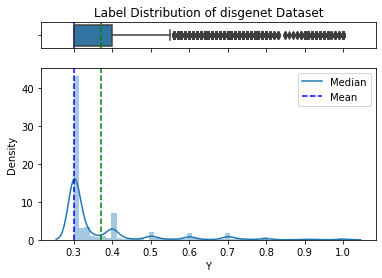

In [18]:
data.label_distribution()

Este gráfico permite observar a associação distributiva do Y - apresentando mediana em 0.3 e média próxima de 0.4. Apresentar mediana de 0.3 e média próxima de 0.4 sugere que a distribuição dos dados pode ser assimétrica, com uma concentração mais significativa de valores menores puxando a mediana para baixo, enquanto alguns valores mais altos podem estar a afetar a média.

A forma do gráfico de densidade sugere que a maioria das observações caem perto do valor zero, com alguns picos que indicam possíveis agrupamentos de dados ou valores mais frequentes.

### 1.3 Pré-processamento dos dados

Valores omissos podem indicar problemas na interpretação de dados. Para garantir a precisão e fiabilidade dos resultados deste projeto, é essencial lidar com valores omissos de maneira adequada. Ignorar esses valores pode levar a conclusões erróneas ou a resultados enviesados. Por esse motivo, fez-se a verificação da presença de valores omissos neste dataset:

In [19]:
df.isnull()

,Gene_ID,Gene,Disease_ID,Disease,Y
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
52471,False,False,False,False,False
52472,False,False,False,False,False
52473,False,False,False,False,False
52474,False,False,False,False,False


In [20]:
print(df.isnull().sum())

Gene_ID       0
Gene          0
Disease_ID    0
Disease       0
Y             0
dtype: int64


Não há valores omissos, pelo que não é necessário proceder à remoção dos mesmos.

Pelo mesmo motivo, procedeu-se à verificação da existência de valores duplicados:

In [21]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
52471    False
52472    False
52473    False
52474    False
52475    False
Length: 52476, dtype: bool

In [22]:
print(df.duplicated().sum())

0


In [23]:
pares = df[['Disease_ID', 'Gene_ID']].drop_duplicates().shape[0]
print(f'Número de pares gene-doença (sem duplicados): {pares}')

Número de pares gene-doença (sem duplicados): 52476


In [24]:
duplicados = df[['Disease_ID', 'Gene_ID']].duplicated(keep=False)
print(f'Número de pares duplicados: {duplicados.sum()}')

Número de pares duplicados: 0


In [25]:
duplicados_y = df[['Disease_ID', 'Gene_ID', 'Y']].duplicated(keep=False)
print(f'Número de combinações duplicadas: {duplicados_y.sum()}')

Número de combinações duplicadas: 0


In [26]:
for i in range(len(df)):
    if duplicados[i]:
        print(f"Genes: {df['Gene_ID'][i]}, Doenças: {df['Disease_ID'][i]}, Y: {df['Y'][i]}")

O dataset não tem valores duplicados.

O dataset apresentado contém várias ontologias. Por esse motivo, foi selecionada a ontologia do fenótipo humano. Para isso, procedeu-se à filtração do dataset por remoção das linhas com genes que não pertecem ao genoma humano:

In [27]:
#Lista de aminoácidos na tabela de transcrição humana
aminoacidos_transcricao_humana = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

#Filtrar sequências de genes com base nos aminoácidos na tabela de transcrição humana
df_humano = df[df['Gene'].apply(lambda gene: all(aa in aminoacidos_transcricao_humana for aa in gene))]


Desta forma, o dataset contém apenas as sequências de genes que têm os aminoácidos presentes na tabela de transcrição humana.

In [28]:
len(df)-len(df_humano)

163

In [29]:
df_humano

,Gene_ID,Gene,Disease_ID,Disease,Y
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30
...,...,...,...,...,...
52471,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C0029172,Oral Submucous Fibrosis: Irreversible FIBROSIS...,0.31
52472,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C2239176,Liver carcinoma: Hepatocellular carcinoma is t...,0.40
52473,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C0087031,Juvenile-Onset Still Disease: An inflammatory ...,0.30
52474,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C3495559,Juvenile arthritis: Juvenile arthritis (JUVAR)...,0.30


Foram removidas 163 linhas.

In [31]:
# Redefinir os índices dos DataFrames
df_humano.reset_index(drop=True, inplace=True)

#### Adição de Outros Descritores

As sequências de cada gene que o nosso dataset contém correspondem a sequências de aminoácidos que compõem uma proteína, sendo a representação fornecida uma sequência de uma proteína codificada pelo gene correspondente. Por esse motivo e com recurso ao PyPro, procedeu-se à pesquisa de descritores relacionados com essas sequências:

In [32]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from propy import PyPro
from propy.PyPro import GetProDes

more_gene_descriptors = []

for i in range(len(df_humano)):
    protein = ProteinAnalysis(df_humano['Gene'][i])
    DesObject = PyPro.GetProDes(df_humano['Gene'][i])
    descriptors = [
        protein.length,
        protein.molecular_weight(),
        protein.isoelectric_point(),
        DesObject.GetCTD(),
    ]
    more_gene_descriptors.append(descriptors)

In [33]:
for i in range(0, len(more_gene_descriptors)):
    
    dict1 = {'Length': more_gene_descriptors[i][0],
        'Molecular Weight': more_gene_descriptors[i][1],
        'Isoelectric_Point': more_gene_descriptors[i][2]}
    
    dict2 = more_gene_descriptors[i][3]
    
    dict_combined = {**dict1, **dict2}
    
    for key, value in dict_combined.items():
        col_name = key
        df_humano.at[i, col_name] = value

In [34]:
df_humano.head()

,Gene_ID,Gene,Disease_ID,Disease,Y,Length,Molecular Weight,Isoelectric_Point,_PolarizabilityC1,_PolarizabilityC2,...,_HydrophobicityD2001,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2075,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30,495.0,54252.8523,5.560922,0.335,0.459,...,0.404,25.657,49.697,75.152,100.0,0.202,20.404,46.465,72.929,99.394
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30,495.0,54252.8523,5.560922,0.335,0.459,...,0.404,25.657,49.697,75.152,100.0,0.202,20.404,46.465,72.929,99.394
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50,1474.0,163289.0320,6.027684,0.313,0.463,...,0.136,28.223,51.764,76.662,100.0,0.068,22.592,48.304,72.592,99.796
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31,1474.0,163289.0320,6.027684,0.313,0.463,...,0.136,28.223,51.764,76.662,100.0,0.068,22.592,48.304,72.592,99.796
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30,1474.0,163289.0320,6.027684,0.313,0.463,...,0.136,28.223,51.764,76.662,100.0,0.068,22.592,48.304,72.592,99.796


In [35]:
#Concatenar os DataFrames
df_concat = pd.merge(df_humano, meta_gene, on='Gene_ID', how='left')
df_concat = pd.merge(df_concat, meta_disease, on='Disease_ID', how='left')

In [36]:
df_concat

,Gene_ID,Gene,Disease_ID,Disease,Y,Length,Molecular Weight,Isoelectric_Point,_PolarizabilityC1,_PolarizabilityC2,...,protein_class_name,protein_class,NofDiseases,NofPmids_x,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,NofGenes,NofPmids_y
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30,495.0,54252.8523,5.560922,0.335,0.459,...,Receptor,DTO_05007575,27,20,Hepatomegaly,phenotype,C23;C06,Finding,523,30
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30,495.0,54252.8523,5.560922,0.335,0.459,...,Receptor,DTO_05007575,27,20,Schizophrenia,disease,F03,Mental or Behavioral Dysfunction,2872,6365
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50,1474.0,163289.0320,6.027684,0.313,0.463,...,Enzyme modulator,DTO_05007584,147,145,Alzheimer's Disease,disease,C10;F03,Disease or Syndrome,3397,15526
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31,1474.0,163289.0320,6.027684,0.313,0.463,...,Enzyme modulator,DTO_05007584,147,145,Malignant tumor of colon,disease,C06;C04,Neoplastic Process,2969,5739
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30,1474.0,163289.0320,6.027684,0.313,0.463,...,Enzyme modulator,DTO_05007584,147,145,Colonic Neoplasms,group,C06;C04,Neoplastic Process,947,1207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52308,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C0029172,Oral Submucous Fibrosis: Irreversible FIBROSIS...,0.31,332.0,37833.2459,6.424648,0.316,0.419,...,NaN,NaN,248,398,Oral Submucous Fibrosis,disease,C07,Disease or Syndrome,106,86
52309,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C2239176,Liver carcinoma: Hepatocellular carcinoma is t...,0.40,332.0,37833.2459,6.424648,0.316,0.419,...,NaN,NaN,248,398,Liver carcinoma,disease,C06;C04,Neoplastic Process,5725,15705
52310,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C0087031,Juvenile-Onset Still Disease: An inflammatory ...,0.30,466.0,54204.9501,5.909175,0.251,0.504,...,NaN,NaN,13,5,Juvenile-Onset Still Disease,disease,C17;C05;C20,Disease or Syndrome,171,17
52311,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C3495559,Juvenile arthritis: Juvenile arthritis (JUVAR)...,0.30,466.0,54204.9501,5.909175,0.251,0.504,...,NaN,NaN,13,5,Juvenile arthritis,disease,C17;C05;C20,Disease or Syndrome,450,386


Remoção de Valores Omissos do novo dataset criado:

In [37]:
null_values = df_concat.isnull().sum()
print(null_values)

Gene_ID                   0
Gene                      0
Disease_ID                0
Disease                   0
Y                         0
                       ... 
diseaseType               0
diseaseClass           1948
diseaseSemanticType       0
NofGenes                  0
NofPmids_y                0
Length: 169, dtype: int64


In [38]:
df_semNAN = df_concat.dropna()

In [39]:
df_semNAN.shape

(31218, 169)

In [40]:
len(df_concat) - len(df_semNAN)

21095

In [41]:
df_semNAN.reset_index(drop=True, inplace=True)

Foram removidas 21 095 linhas.

Remoção de duplicados:

In [42]:
df_tratado = df_semNAN.drop_duplicates(['Disease_ID', 'Gene_ID'])

In [43]:
df_tratado.shape

(31218, 169)

Não há valores duplicados.

### Feature Selection

As características ou variáveis que descrevem os genes e as doenças em estudo podem incluir uma ampla gama de informações, como expressão genética, variantes genéticas, interações proteicas, dados funcionais, informações sobre vias biológicas, entre outras. 

A importância da seleção de features está relacionada com a procura de um conjunto de características que contribuam significativamente para o desempenho do estudo GDA, enquanto se evita a inclusão de características irrelevantes ou redundantes. Esta seleção é também importante para melhorar a eficiência computacional, o desempenho do estudo (nem todas as features contribuem igualmente para a previsão), a prevenção de overfitting, facilitar a sua interpretação (a redução das features torna o modelo mais simples, permitindo entender as relações biológicas subjacentes e validar as descobertas do modelo), diminuir a redução de ruído.

In [44]:
df_tratado

,Gene_ID,Gene,Disease_ID,Disease,Y,Length,Molecular Weight,Isoelectric_Point,_PolarizabilityC1,_PolarizabilityC2,...,protein_class_name,protein_class,NofDiseases,NofPmids_x,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,NofGenes,NofPmids_y
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30,495.0,54252.8523,5.560922,0.335,0.459,...,Receptor,DTO_05007575,27,20,Hepatomegaly,phenotype,C23;C06,Finding,523,30
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30,495.0,54252.8523,5.560922,0.335,0.459,...,Receptor,DTO_05007575,27,20,Schizophrenia,disease,F03,Mental or Behavioral Dysfunction,2872,6365
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50,1474.0,163289.0320,6.027684,0.313,0.463,...,Enzyme modulator,DTO_05007584,147,145,Alzheimer's Disease,disease,C10;F03,Disease or Syndrome,3397,15526
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31,1474.0,163289.0320,6.027684,0.313,0.463,...,Enzyme modulator,DTO_05007584,147,145,Malignant tumor of colon,disease,C06;C04,Neoplastic Process,2969,5739
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30,1474.0,163289.0320,6.027684,0.313,0.463,...,Enzyme modulator,DTO_05007584,147,145,Colonic Neoplasms,group,C06;C04,Neoplastic Process,947,1207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31213,317772,MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGA...,C0006142,Malignant neoplasm of breast: BRCA1- and BRCA2...,0.30,130.0,13995.1257,10.883117,0.323,0.423,...,Nucleic acid binding,DTO_05007557,1,0,Malignant neoplasm of breast,disease,C04;C17,Neoplastic Process,6941,33483
31214,319100,MSSNSSLLVAVQLCYANVNGSCVKIPFSPGSRVILYIVFGFGAVLA...,C0005586,Bipolar Disorder: A disorder of the brain that...,0.31,345.0,38450.7618,8.275500,0.310,0.435,...,G-protein coupled receptor,DTO_02300001,12,18,Bipolar Disorder,disease,F03,Mental or Behavioral Dysfunction,1183,1819
31215,319100,MSSNSSLLVAVQLCYANVNGSCVKIPFSPGSRVILYIVFGFGAVLA...,C0011581,Depressive disorder: An affective disorder man...,0.31,345.0,38450.7618,8.275500,0.310,0.435,...,G-protein coupled receptor,DTO_02300001,12,18,Depressive disorder,disease,F03,Mental or Behavioral Dysfunction,1719,4094
31216,326625,MAVCGLGSRLGLGSRLGLRGCFGAARLLYPRFQSRGPQGVEDGDRP...,C0011581,Depressive disorder: An affective disorder man...,0.31,250.0,27387.9391,8.859777,0.368,0.392,...,Enzyme,DTO_05007624,46,45,Depressive disorder,disease,F03,Mental or Behavioral Dysfunction,1719,4094


Pelos motivos descritos acima, do dataframe 'df_tratado' foi criado um dataframe com todas as features designado 'colunas_selecionadas', a partir do qual foi criado um novo dataframe apenas com as features numéricas designadas 'colunas_num', para em seguida serem selecionadas as features mais relevantes:

In [51]:
colunas_selecionadas = df_tratado.iloc[:, 5:]

In [52]:
colunas_num = colunas_selecionadas.select_dtypes(include=['number','float64'])

colunas_num.head()


,Length,Molecular Weight,Isoelectric_Point,_PolarizabilityC1,_PolarizabilityC2,_PolarizabilityC3,_SolventAccessibilityC1,_SolventAccessibilityC2,_SolventAccessibilityC3,_SecondaryStrC1,...,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100,DSI,DPI,PLI,NofDiseases,NofPmids_x,NofGenes,NofPmids_y
0,495.0,54252.8523,5.560922,0.335,0.459,0.206,0.455,0.261,0.285,0.444,...,46.465,72.929,99.394,0.700,0.538,4.991700e-09,27,20,523,30
1,495.0,54252.8523,5.560922,0.335,0.459,0.206,0.455,0.261,0.285,0.444,...,46.465,72.929,99.394,0.700,0.538,4.991700e-09,27,20,2872,6365
2,1474.0,163289.0320,6.027684,0.313,0.463,0.224,0.421,0.291,0.288,0.417,...,48.304,72.592,99.796,0.529,0.769,4.522900e-11,147,145,3397,15526
3,1474.0,163289.0320,6.027684,0.313,0.463,0.224,0.421,0.291,0.288,0.417,...,48.304,72.592,99.796,0.529,0.769,4.522900e-11,147,145,2969,5739
4,1474.0,163289.0320,6.027684,0.313,0.463,0.224,0.421,0.291,0.288,0.417,...,48.304,72.592,99.796,0.529,0.769,4.522900e-11,147,145,947,1207


#### Standardização

Padronizar características numéricas garante que estas estejam dentro de uma escala semelhante, evitando que certas características dominem o processo de aprendizagem simplesmente porque têm escalas ou unidades maiores. Desta forma, obtemos os nossos descritores numéricos com desvio padrão = 1 e média = 0, com recurso à biblioteca 'sklearn'.

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_descriptors = scaler.fit_transform(colunas_num)
scaled_descriptors

array([[-0.14131078, -0.14891483, -0.97753032, ..., -0.40086717,
        -0.31043434, -0.37564844],
       [-0.14131078, -0.14891483, -0.97753032, ..., -0.40086717,
         1.12770437,  0.43324782],
       [ 0.64118209,  0.63414359, -0.68809867, ..., -0.34884969,
         1.44912745,  1.60298714],
       ...,
       [-0.26120243, -0.26239973,  0.70573677, ..., -0.40169945,
         0.42179805,  0.14327096],
       [-0.33713381, -0.34184892,  1.06803774, ..., -0.39046367,
         0.42179805,  0.14327096],
       [-0.33713381, -0.34184892,  1.06803774, ..., -0.39046367,
        -0.62940848, -0.37615919]])

A seleção de características com base na variância é um método para remover recursos com baixa variabilidade, supondo que estes recursos possam não ser muito informativos para o modelo. O código a seguir usa a classe 'VarianceThreshold' da biblioteca 'sk-learn' para selecionar características com uma variância acima de um limiar de 1.0:

In [54]:
from sklearn.feature_selection import VarianceThreshold

filter_df = VarianceThreshold(threshold=1.0)
data_filtered = filter_df.fit_transform(scaled_descriptors)
selected_columns = colunas_num.columns[filter_df.get_support()]

data_filtered.shape, selected_columns

((31218, 55),
 Index(['Length', 'Molecular Weight', '_PolarizabilityC2', '_PolarizabilityC3',
        '_ChargeC2', '_NormalizedVDWVC2', '_NormalizedVDWVC3',
        '_PolarizabilityT12', '_SolventAccessibilityT13', '_ChargeT13',
        '_NormalizedVDWVT23', '_HydrophobicityT13', '_PolarizabilityD1050',
        '_PolarizabilityD2025', '_PolarizabilityD2050', '_PolarizabilityD2100',
        '_PolarizabilityD3001', '_PolarizabilityD3100',
        '_SolventAccessibilityD1001', '_SolventAccessibilityD1100',
        '_SolventAccessibilityD2025', '_SolventAccessibilityD3001',
        '_SolventAccessibilityD3050', '_SecondaryStrD1025',
        '_SecondaryStrD1050', '_SecondaryStrD2100', '_SecondaryStrD3001',
        '_SecondaryStrD3050', '_SecondaryStrD3075', '_ChargeD1075',
        '_ChargeD2001', '_ChargeD2025', '_ChargeD3001', '_ChargeD3025',
        '_ChargeD3050', '_ChargeD3100', '_PolarityD1025', '_PolarityD2001',
        '_PolarityD2050', '_PolarityD2100', '_PolarityD3100',
        '_N

Desta forma, das 157 colunas numéricas iniciais, o nosso novo dataframe denominado 'data_filtered_df' apresenta agora 55 colunas. 

In [55]:
data_filtered_df = pd.DataFrame(data_filtered, columns=colunas_num.columns[filter_df.get_support()])

In [56]:
data_filtered_df = data_filtered_df.reset_index(drop = True)

Seguidamente, procedeu-se à junção das colunas do dataset inicial 'Gene_ID', 'Gene', 'Disease_ID' e 'Y' com o dataset filtrado:

In [57]:
dataset_filtered = pd.concat([df_tratado.iloc[:, :5], data_filtered_df], axis=1)
dataset_filtered

,Gene_ID,Gene,Disease_ID,Disease,Y,Length,Molecular Weight,_PolarizabilityC2,_PolarizabilityC3,_ChargeC2,...,_NormalizedVDWVD3100,_HydrophobicityD1025,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3075,_HydrophobicityD3100,PLI
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30,-0.141311,-0.148915,0.544780,-1.100232,0.364638,...,-0.739538,0.878123,0.324687,0.118570,0.344556,-0.209447,-0.635138,-0.076130,0.104719,-0.945468
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30,-0.141311,-0.148915,0.544780,-1.100232,0.364638,...,-0.739538,0.878123,0.324687,0.118570,0.344556,-0.209447,-0.635138,-0.076130,0.104719,-0.945468
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50,0.641182,0.634144,0.649670,-0.592836,0.555497,...,0.258046,-0.562708,0.922611,0.526594,0.344556,-0.378468,-0.255664,-0.140377,0.330608,-0.945468
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31,0.641182,0.634144,0.649670,-0.592836,0.555497,...,0.258046,-0.562708,0.922611,0.526594,0.344556,-0.378468,-0.255664,-0.140377,0.330608,-0.945468
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30,0.641182,0.634144,0.649670,-0.592836,0.555497,...,0.258046,-0.562708,0.922611,0.526594,0.344556,-0.378468,-0.255664,-0.140377,0.330608,-0.945468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31213,317772,MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGA...,C0006142,Malignant neoplasm of breast: BRCA1- and BRCA2...,0.30,-0.433047,-0.438031,-0.399224,0.252824,-0.665999,...,0.383717,-0.548128,-1.531304,-1.643810,-1.012702,0.505740,1.696166,0.392094,-5.173904,0.445792
31214,319100,MSSNSSLLVAVQLCYANVNGSCVKIPFSPGSRVILYIVFGFGAVLA...,C0005586,Bipolar Disorder: A disorder of the brain that...,0.31,-0.261202,-0.262400,-0.084556,0.281013,2.006022,...,0.276211,1.206553,0.019666,-0.250764,0.174017,-0.098448,-0.202419,0.498283,0.445239,-0.907741
31215,319100,MSSNSSLLVAVQLCYANVNGSCVKIPFSPGSRVILYIVFGFGAVLA...,C0011581,Depressive disorder: An affective disorder man...,0.31,-0.261202,-0.262400,-0.084556,0.281013,2.006022,...,0.276211,1.206553,0.019666,-0.250764,0.174017,-0.098448,-0.202419,0.498283,0.445239,-0.907741
31216,326625,MAVCGLGSRLGLGSRLGLRGCFGAARLLYPRFQSRGPQGVEDGDRP...,C0011581,Depressive disorder: An affective disorder man...,0.31,-0.337134,-0.341849,-1.212117,-0.141817,-0.322453,...,-1.099128,-0.001741,-0.434254,-0.216417,0.109330,0.040301,0.474148,0.128051,0.445239,-0.936122


Após o processamento, o dataset designa-se 'dataset_final':

In [58]:
dataset_final = dataset_filtered 

In [59]:
dataset_final.to_csv('./data/dataset_final.csv')

#### Gráficos exploratórios:

Os gráficos exploratórios desempenham um papel crucial no contexto de Associação Gene-Doença (GDA), pois permitem uma melhor visualização dos dados, permitindo visualizar as distribuições de dados relacionados com os genes e as doenças e, consequentemente, auxilia na identificação de padrões, tendências e possíveis outliers, podendo revelar padrões visuais que indicam associações entre genes e doenças. 

In [ ]:
import matplotlib.pyplot as plt

##### Histograma da coluna 'Y' (valor de associação) para visualizar a sua distribuição:

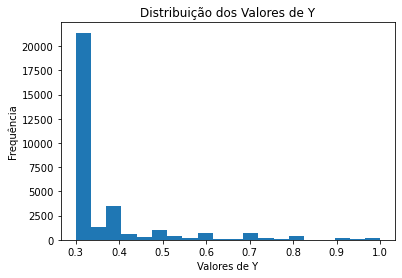

In [ ]:
plt.hist(dataset_final['Y'], bins=20)
plt.xlabel('Valores de Y')
plt.ylabel('Frequência')
plt.title('Distribuição dos Valores de Y')
plt.show()

O histograma apresenta uma barra bastante elevada no primeiro intervalo à esquerda, indicando que uma grande quantidade de valores de Y está concentrada em torno de 0,3. As barras seguintes diminuem drasticamente em altura, sugerindo que valores mais altos de Y são muito menos frequentes neste conjunto de dados.

##### Gráfico de Barras para Valores de Associações por Gene:

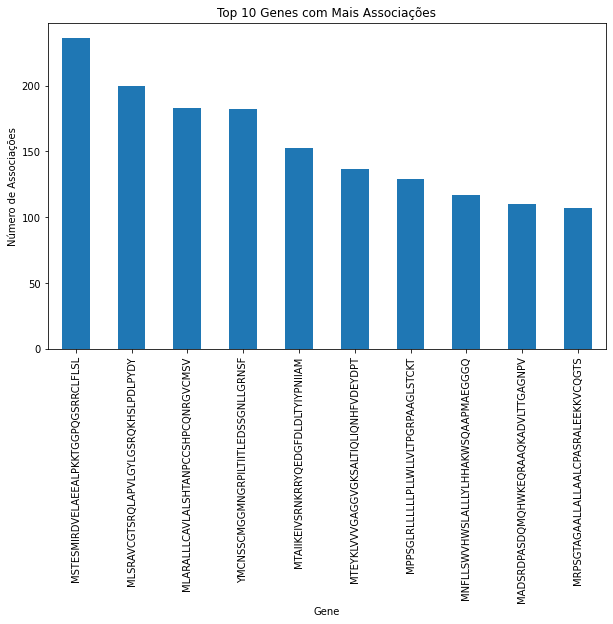

In [ ]:
gene_counts = dataset_final['Gene'].value_counts().head(10)
fig, ax = plt.subplots(figsize=(10, 6))
gene_counts.plot(kind='bar', ax=ax)

labels = [text[:35] for text in gene_counts.index]
ax.set_xticklabels(labels)

plt.xlabel('Gene')
plt.ylabel('Número de Associações')
plt.title('Top 10 Genes com Mais Associações')
plt.show()

O gene que apresenta mais associações a doenças corresponde ao Gene TNF, um gene que produz uma citocina secretada por macrófagos. Com diversas funções, incluindo indução de morte celular em tumores, atua como pirogénio causando febre e regulação do sistema imunológico. Também está envolvido em processos relacionados à resistência à insulina, angiogénese, além de impactar a função das células T reguladoras em condições como a artrite reumatoide.

##### Gráfico de Barras para Valores de Associações por Doença:

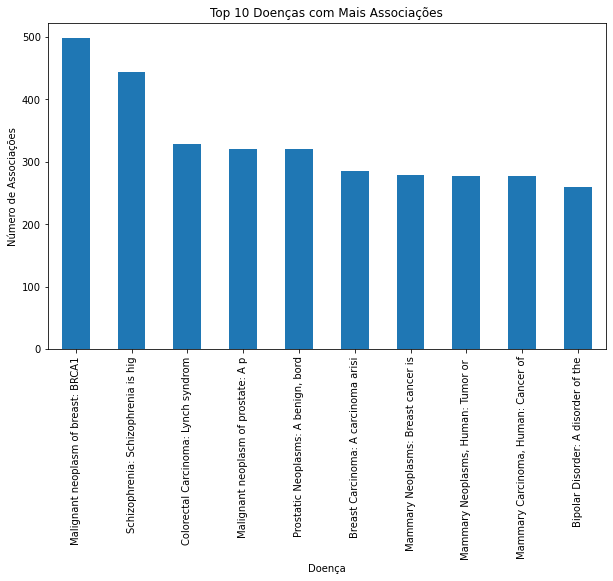

In [ ]:
gene_counts = dataset_final['Disease'].value_counts().head(10)
fig, ax = plt.subplots(figsize=(10, 6))
gene_counts.plot(kind='bar', ax=ax)

labels = [text[:35] for text in gene_counts.index]
ax.set_xticklabels(labels)

plt.xlabel('Doença')
plt.ylabel('Número de Associações')
plt.title('Top 10 Doenças com Mais Associações')
plt.show()

A doença com mais associações a genes corresponde à Neoplasia Maligna da Mama, mais especificamente, ao gene BRAC1. A Neoplasia Maligna da Mama refere-se a um tumor cancerígeno no tecido mamário, uma condição grave e comum em mulheres, embora também possa afetar homens. 

O gene BRAC1 é um gene associado ao cancro da mama e ovário. Mutações no gene BRAC1 estão relacionadas a um aumento significativo no risco de desenvolver estes tumores. Pessoas com mutações hereditárias no BRAC1 têm maior probabilidade de desenvolver esses tipos de cancro em comparação com a população em geral.

##### Gráfico de Dispersão para Relacionar 'Y' com Genes

Como o nosso dataset é relativamente grande (contém bastantes dados) foram selecionadas 50 linhas de forma aleatória no dataset para evitar a sobreposição gráfica: 

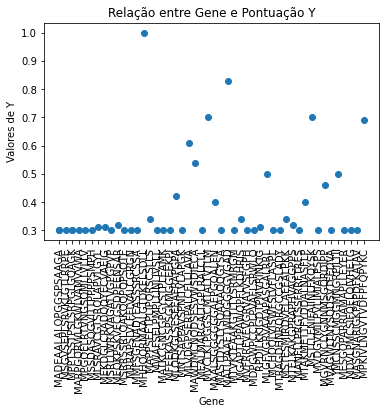

In [ ]:
gene_df = dataset_final.sample(n = 50, random_state=42) #selecionar 50 linhas aleatórias do dataset

gene_df['Shortened_Gene'] = gene_df['Gene'].str.slice(0, 20)

plt.scatter(gene_df['Shortened_Gene'], gene_df['Y'])
plt.xlabel('Gene')
plt.ylabel('Valores de Y')
plt.title('Relação entre Gene e Pontuação Y')
plt.xticks(rotation=90)
plt.show()

Alguns dos genes selecionados aleatoriamente apresentam valores de "Y" mais próximo de 1 indicando uma forte associação positiva entre o gene e a doença. Isso significa que, quando o gene está presente ou ativo, a probabilidade de a doença estar associada a esse gene é alta. 

É possível notar que a maioria dos valores de "Y" está próxima de 0.3, o que sugere que as associações entre os genes e as doenças nesta amostra de dados são, na sua maioria, moderadas. Em termos de associação gene-doença, valores em torno de 0.3 podem indicar que a presença ou atividade do gene tem uma relação moderada com a doença em questão.

##### Gráfico de Dispersão para Relacionar 'Y' com Doenças:

Como o nosso dataset é relativamente grande (contém bastantes dados) foram selecionadas 50 linhas de forma aleatória no dataset para evitar a sobreposição gráfica: 

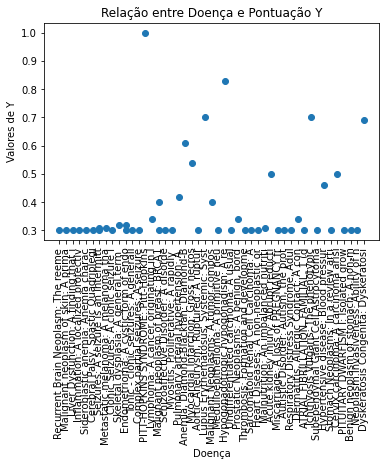

In [ ]:
disease_df = dataset_final.sample(n = 50, random_state=42) #selecionar 50 linhas aleatórias do dataset

disease_df['Shortened_Disease'] = disease_df['Disease'].str.slice(0, 35)

plt.scatter(disease_df['Shortened_Disease'], disease_df['Y'])
plt.xlabel('Doença')
plt.ylabel('Valores de Y')
plt.title('Relação entre Doença e Pontuação Y')
plt.xticks(rotation=90)
plt.show()

Doenças com valores de "Y" próximos de 1 sugerem que a presença ou atividade do gene específico a que estão associadas têm uma associação significativa ou até mesmo crucial com o desenvolvimento ou progressão da doença. Esses genes podem ser considerados como potenciais biomarcadores ou alvos terapêuticos importantes para a doença em questão.

Nesta amostra, os genes com valores de "Y" próximos de 0.3 podem ainda estar associados à doença, mas a força desta associação é menor em comparação com genes que têm valores próximos de 1. Esses genes podem desempenhar papéis mais subtis ou menos diretos na patogénese da doença.

##### Gráfico Distribuição do Comprimento dos Genes

Text(0.5, 1.0, 'Distribuição do Comprimento dos Genes')

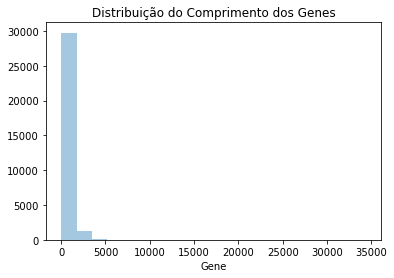

In [ ]:
import seaborn as sns
sns.distplot(dataset_final.Gene.str.len(), kde=False, bins=20).set_title('Distribuição do Comprimento dos Genes')

Este gráfico permite observar que grande parte das sequências genéticas representativas dos genes presentes no nosso dataset apresentam cerca de 30 000 aminoácidos.

## Análise não supervisionada

### 2.1 - Técnicas de redução de dimensionalidade e de visualização

As técnicas de redução de dimensionalidade e de visualização referem-se ao processo de reduzir o número de variáveis (dimensões) no conjunto de dados, mantendo o máximo de informações possível, permitindo simplificar a complexidade dos dados, eliminar ruídos e redundâncias e salientar as características mais importantes, através de uma representação gráfica ou visual dos dados de forma a torná-los compreensíveis para análise humana.

Contextualizando, estas técnicas podem ser utéis para reduzir a dimensão dos dados gene-doença, uma vez que o número de genes e doenças presentes no dataset é elevado, permitindo uma visualização mais fácil e a identificação de padrões relevantes.

#### Principal Component Analysis (PCA)

O PCA (Principal Component Analysis) é uma técnica de redução de dimensionalidade utilizada para identificar padrões nos dados, visando a representação dos dados num novo espaço de menor dimensão (com menos variáveis) mantendo o máximo possível da variabilidade original.

In [ ]:
from sklearn.decomposition import PCA

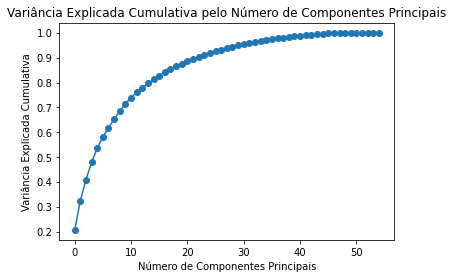

In [ ]:
pca = PCA()
X_pca = pca.fit(dataset_final.iloc[:, 5:])

cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Variância Explicada Cumulativa pelo Número de Componentes Principais')
plt.show()

Este gráfico representa a variância explicada cumulativa em função do número de componentes principais. A linha azul no gráfico mostra a proporção acumulada da variância explicada pelos componentes principais do conjunto de dados. Cada ponto no gráfico representa a variância total explicada por todos os componentes principais até aquele ponto. Por exemplo, o primeiro ponto mostra a variância explicada pelo primeiro componente principal, o segundo ponto mostra a variância explicada pela combinação do primeiro e segundo componentes principais, e assim sucessivamente.

A curva é íngreme no início, indicando que os primeiros componentes principais explicam uma grande parte da variância total dos dados. Isto pode indicar que existem poucas variáveis que contribuem significativamente para a variação dos dados.

Conforme nos movemos para a direita ao longo do eixo do x (aumentando o número de componentes principais), a taxa de aumento da variância explicada diminui, o que é indicado pela curva que se torna mais plana. Isto pode indicar que cada componente adicional contribui cada vez menos para a explicação da variância total.

Quando a curva atinge o componente 31, a linha começa a estabilizar perto do valor 1.0 na variância explicada cumulativa, o que sugere que a inclusão de componentes adicionais além desse ponto contribui muito pouco para o aumento da variância explicada.

No contexto GDA, esta interpretação gráfica pode significar que um número relativamente pequeno de componentes principais já é suficiente para capturar a maioria das informações relevantes dos dados genéticos em relação às doenças em questão. Portanto, pode não ser necessário examinar todos os componentes para entender as relações nos dados, o que pode ser útil para simplificar modelos de análise genética e identificar os principais fatores que influenciam a associação entre genes e doenças.

In [ ]:
import numpy as np
threshold_variance = 0.95

num_components = np.argmax(cumulative_explained_variance >= threshold_variance) + 1

print(f'Número de Componentes para {threshold_variance * 100}% de Variância Explicada: {num_components}')

Número de Componentes para 95.0% de Variância Explicada: 31


Este PCA aplicado à Associação Gene-Doença (GDA), o resultado de 31 componentes significa que, ao reter 31 componentes principais, preservamos cerca de 95% da variância original dos dados. A variância explicada refere-se à quantidade de informação dos dados que é capturada pelos componentes principais retidos.

Assim sendo, ao escolher 31 componentes, reduzimos a dimensionalidade dos dados (o que facilita a análise) preservando uma quantidade significativa de informação.

In [ ]:
pca = PCA(n_components=31)
X_pca = pca.fit_transform(dataset_final.iloc[:, 5:])

In [ ]:
data_pca = {f'PCA_Component_{i+1}': X_pca[:, i] for i in range(pca.n_components)}
df_pca_components = pd.DataFrame(data_pca)

df_pca_components

,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,...,PCA_Component_22,PCA_Component_23,PCA_Component_24,PCA_Component_25,PCA_Component_26,PCA_Component_27,PCA_Component_28,PCA_Component_29,PCA_Component_30,PCA_Component_31
0,-0.382094,0.116692,-0.937398,-2.988049,-0.554300,0.928608,-0.297865,-0.128142,-0.017417,-0.335904,...,-0.731927,-0.791194,0.040654,0.119553,-0.346768,0.000094,-0.198865,-0.115341,0.140060,0.219665
1,-0.382094,0.116692,-0.937398,-2.988049,-0.554300,0.928608,-0.297865,-0.128142,-0.017417,-0.335904,...,-0.731927,-0.791194,0.040654,0.119553,-0.346768,0.000094,-0.198865,-0.115341,0.140060,0.219665
2,-2.228497,1.119063,-1.293395,-0.703441,-0.424419,0.811893,-0.575810,0.592475,-0.734296,0.656203,...,0.136354,-0.496726,0.007251,0.017155,-0.089613,-0.189881,0.143819,-0.193269,0.006858,0.104741
3,-2.228497,1.119063,-1.293395,-0.703441,-0.424419,0.811893,-0.575810,0.592475,-0.734296,0.656203,...,0.136354,-0.496726,0.007251,0.017155,-0.089613,-0.189881,0.143819,-0.193269,0.006858,0.104741
4,-2.228497,1.119063,-1.293395,-0.703441,-0.424419,0.811893,-0.575810,0.592475,-0.734296,0.656203,...,0.136354,-0.496726,0.007251,0.017155,-0.089613,-0.189881,0.143819,-0.193269,0.006858,0.104741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31213,4.757666,-2.871447,-0.916958,2.213616,-1.525436,-3.169654,2.287827,-2.217799,3.584977,3.472069,...,-0.306834,1.156823,-0.062633,-0.020962,-1.287208,-1.279443,1.847659,-0.979426,0.146476,1.665143
31214,0.401849,-1.021741,-1.095435,-2.966730,0.986419,-0.274161,-1.245794,0.100703,-2.636814,0.419745,...,0.840517,-0.197475,-0.869388,-0.713395,0.073066,-1.202153,0.220475,-0.851327,-0.647965,0.084776
31215,0.401849,-1.021741,-1.095435,-2.966730,0.986419,-0.274161,-1.245794,0.100703,-2.636814,0.419745,...,0.840517,-0.197475,-0.869388,-0.713395,0.073066,-1.202153,0.220475,-0.851327,-0.647965,0.084776
31216,1.941754,-2.439856,-1.190556,0.519973,-0.218948,-1.382102,0.372076,0.519669,0.036716,-1.449452,...,0.247747,0.639907,-0.987736,-0.260644,-1.157938,-0.349738,-0.693833,0.302770,0.545479,0.349229


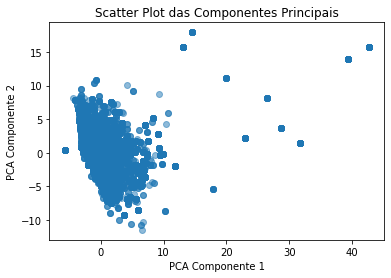

In [ ]:
plt.scatter(df_pca_components['PCA_Component_1'], df_pca_components['PCA_Component_2'], alpha=0.5)
plt.title('Scatter Plot das Componentes Principais')
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.show()

Este scatter plot (gráfico de dispersão) das duas primeiras componentes principais obtidas através da uma análise PCA permite visualizar a distribuição dos dados no novo espaço de características criado pelos dois primeiros componentes principais.

O eixo do x representa os valores do primeiro componente principal (PCA Componente 1), enquanto que o eixo do y representa os valores do segundo componente principal (PCA Componente 2). Estes dois componentes são as direções nos dados originais que capturam a maior quantidade de variação.
Os pontos no gráfico representam as amostras do conjunto de dados projetadas nestes dois primeiros componentes principais. 

Observamos que há uma dispersão considerável ao longo do primeiro componente principal, o que indica que este captura uma quantidade significativa de variação nos dados. A distribuição dos pontos ao longo do PCA Componente 1 é mais ampla do que ao longo do PCA Componente 2, sugerindo que o primeiro componente principal tem um papel mais importante na explicação da variação dos dados.
A distribuição dos pontos não mostra clusters claramente definidos, mas parece haver uma tendência para que os valores mais altos do PCA Componente 1 estarem associados a valores mais altos ou mais baixos do PCA Componente 2, sugerindo talvez uma relação não-linear ou a presença de subgrupos nos dados.

No contexto GDA, este gráfico de dispersão pode ser usado para identificar padrões na expressão genética ou em características genéticas que estão associadas a diferentes condições ou doenças. A ausência de agrupamentos claros é uma informação importante, indicando que a relação entre os componentes e as doenças pode ser mais complexa e requerer análise adicional.

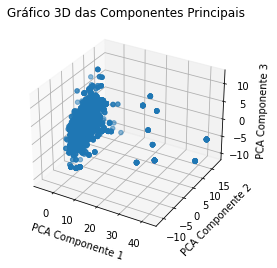

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca_components['PCA_Component_1'], df_pca_components['PCA_Component_2'], df_pca_components['PCA_Component_3'], alpha=0.5)
ax.set_xlabel('PCA Componente 1')
ax.set_ylabel('PCA Componente 2')
ax.set_zlabel('PCA Componente 3')
plt.title('Gráfico 3D das Componentes Principais')
plt.show()

Este gráfico é uma representação tridimensional resultante da análise PCA. O gráfico mostra três eixos, rotulados como PCA Componente 1, PCA Componente 2 e PCA Componente 3, que representam as três primeiras componentes principais obtidas pela análise. Cada ponto no gráfico pode representar uma amostra ou um conjunto de expressões genéticas. A posição de cada ponto é determinada pelos valores das três componentes principais, que são combinações lineares das variáveis originais (neste caso, expressão de genes).

Analisando o gráfico, podemos observar que a maioria dos pontos está concentrada numa "nuvem" que se estende principalmente ao longo do PCA Componente 1 e menos ao longo do PCA Componente 2 e 3. Isto sugere que o PCA Componente 1 captura a maior variação nos dados, o que pode indicar que é o mais significativo em termos de explicar a relação entre a expressão genética e a doença em questão.

Podemos inferir que a sobreposição e a concentração de pontos sugerem que a associação entre os componentes principais e a doença pode não ser clara ou que a expressão genética varia de maneira mais contínua em relação à doença.

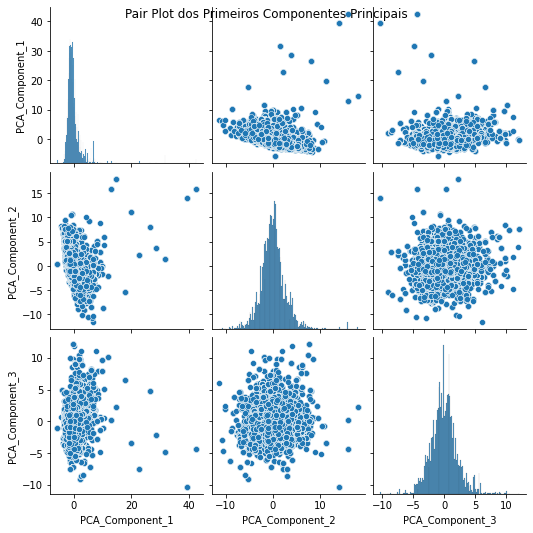

In [ ]:
sns.pairplot(df_pca_components.iloc[:, :3])
plt.suptitle('Pair Plot dos Primeiros Componentes Principais')
plt.show()

Este gráfico é um pair plot, também conhecido como matriz de dispersão, que mostra as relações entre os pares das três primeiras componentes principais resultantes da análise PCA. Este tipo de gráfico é útil para explorar visualmente as relações entre múltiplas variáveis quantitativas.

Cada gráfico na diagonal principal mostra a distribuição de uma componente principal por meio de um histograma, enquanto os gráficos fora da diagonal mostram a dispersão dos pontos para cada par de componentes principais. No contexto GDA, cada ponto representa uma doença, com as suas coordenadas refletindo a contribuição das componentes principais para a expressão genética da doença.

Análise dos gráficos:

1. PCA_Componente_1 vs. PCA_Componente_2: A dispersão dos pontos sugere uma potencial relação entre estas duas componentes, com uma nuvem de pontos mais densa no centro, indicando uma distribuição mais normalizada das amostras.

2. PCA_Componente_1 vs. PCA_Componente_3: Semelhante ao gráfico anterior, há uma distribuição centralizada dos pontos, embora a dispersão pareça ser um pouco mais ampla ao longo do PCA_Componente_3.

3. PCA_Componente_2 vs. PCA_Componente_3: Aqui também vemos uma distribuição central dos pontos, com uma possível correlação entre estas duas componentes, embora pareça haver menos variação ao longo do PCA_Componente_3 em comparação com o PCA_Componente_1.

Os histogramas na diagonal mostram a distribuição univariada para cada componente principal. Nota-se que PCA_Componente_1 tem uma distribuição mais assimétrica com uma cauda longa para os maiores valores, enquanto PCA_Componente_2 e PCA_Componente_3 têm distribuições que parecem ser mais simétricas, indicando uma normalidade maior.

No contexto do nosso problema (GDA):
- A maior variação nos dados parece ser capturada pelo PCA_Componente_1, como indicado pela distribuição assimétrica e pela dispersão dos pontos nos gráficos de dispersão.

- As relações entre as componentes (como PCA_Componente_2 vs. PCA_Componente_3) podem refletir padrões genéticos complexos associados a doenças específicas. No entanto, sem uma separação distinta de clusters, não é evidente uma associação direta entre as componentes principais e grupos distintos de doenças.

#### t-distributed Stochastic Neighbor Embedding (t-SNE)

A técnica t-SNE (t-distributed Stochastic Neighbor Embedding) é uma técnica de redução de dimensionalidade utilizada principalmente para visualizar conjuntos de dados de alta dimensionalidade num espaço de menor dimensão, de forma a preservar a estrutura de proximidade entre os pontos. Pontos que são semelhantes em alta dimensão tendem a ser mapeados próximos no espaço de menor dimensão.

Reduz a dimensionalidade do conjunto de dados original para uma visualização mais clara e compreensível, mantendo as relações de proximidade entre os pontos.

Esta técnica calcula as similaridades entre os pontos no espaço de alta dimensão, usando uma distribuição de probabilidade baseada na distância entre os pontos.

In [72]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, n_iter=500)
tsne_results = tsne.fit_transform(scaled_descriptors)

In [73]:
fig = sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="Y",
    palette=sns.color_palette("hls", 3),
    data=dataset_final,
    legend="full",
).set(title="t-SNE")

ValueError: The palette list has the wrong number of colors.

Este gráfico corresponde a um gráfico de dispersão resultante da análise t-SNE. Cada ponto representa uma associação gene-doença, e a cor de cada ponto corresponde a um valor Y (métrica de confiança para a GDA), variando de 0.3 (vermelho) a 1.0 (azul). A escala de cores, localizada no lado direito do gráfico, mostra essa graduação de cores correspondentes aos diferentes valores de Y.

A disposição dos pontos no espaço bidimensional não mostra agrupamentos claramente definidos, o que pode indicar uma alta interconexão entre os genes e as doenças, ou que a variável Y não é suficiente para discriminar grupos distintos. No entanto, há uma leve concentração de pontos azuis (valores mais altos de Y) no centro do gráfico, sugerindo que associações com maior confiança tendem a estar mais centralizadas, enquanto associações com menor confiança (pontos vermelhos) estão mais dispersas.

### 2.2 - Métodos de clustering

Os métodos de clustering referem-se a técnicas que agrupam dados similares em grupos (clusters) com base nas suas características, identificando padrões intrínsecos nos dados e agrupando elementos similares.

Neste contexto, estes métodos podem ajudar a identificar grupos de genes ou doenças que estão associados de maneira semelhante, possibilitando a análise de conjuntos de genes/doenças com comportamentos comuns. Podem ainda revelar grupos naturais de genes/doenças associados, ajudando a identificar subgrupos funcionais ou patológicos.

#### K-Means

O algoritmo K-Means tem o objetivo de particionar um conjunto de dados em K clusters, onde cada ponto de dados pertence ao cluster cujo centro (média) é mais próximo. Inicialialmente, escolhem-se aleatoriamente K pontos no conjunto de dados como os centroides iniciais. Segue-se a atribuição dos pontos aos clusters cujo centróide é o mais próximo (baseado num métrica de distância - métrica euclidiana). Os centróides são atualizados, ou seja, são calculados novos centróides para cada cluster, tomando a média dos pontos atribuídos a esse cluster. Estes passos são repetidos até que os centróides não mudem significativamente ou um número máximo de iterações seja atingido.

O valor de K (número de clusters) é um parâmetro crucial e muitas vezes requer conhecimento prévio sobre a estrutura dos dados ou métodos para determinar o número ideal de clusters.

In [74]:
from sklearn.cluster import KMeans

In [75]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, max_iter=1000, n_init = 10)

kmeans.fit(scaled_descriptors)

labels = kmeans.labels_

centroids = kmeans.cluster_centers_

pd.crosstab(labels, dataset_final["Y"], rownames=['clusters'])

Y,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00
clusters,,,,,,,,,,,,,,,,,,,,,
0,98,24,6,2,6,3,2,3,3,1,...,0,0,0,0,0,0,1,0,0,2
1,11042,1927,931,596,388,291,217,201,139,137,...,10,9,13,9,7,7,4,2,2,168
2,5150,917,420,288,208,140,105,89,71,68,...,4,5,3,4,2,0,1,2,2,51


Foram selecionados 3 clusters, ou seja, são apresentados na tabela 3 grupos distintos:
* Cluster 0: Contém 5150 genes ou doenças que se enquadram principalmente na faixa de valores de Y = 0.30. 
* Cluster 1: Com 11042 genes ou doenças na faixa de valores de Y = 0.30, este aparenta ser o cluster mais numeroso, tendo uma distribuição mais uniforme em diferentes faixas de valores de Y.
* Cluster 2: O menor cluster, com apenas 98 genes ou doenças com valores de Y = 0.30. A sua distribuição parece ser mais concentrada nas faixas mais baixas de valores de Y.

Contudo, este não nos parece ser o melhor método de agrupamento para o nosso caso. Para conjuntos de dados muito grandes como o nosso, o K-means pode enfrentar limitações em termos de escalabilidade.

#### Dendrograma Hierárquico, método 'single'

Um dendrograma hierárquico é uma representação gráfica de um processo de agrupamento hierárquico, onde os elementos são agrupados com base na sua similaridade. É frequentemente usado em análises de cluster para visualizar como os dados podem ser divididos em grupos. Inicialmente é feito o cálculo da matriz de distância entre todos os pares de elementos. Primeiramente considera-se cada ponto como um cluster individual e em cada etapa, combina-se os dois clusters mais próximos com base na distância calculada. Este processo é repetido até que todos os pontos estejam num único cluster.

Graficamente o processo de agrupamento é feito em forma de árvore, onde os pontos individuais são os "nós" iniciais e os clusters combinados formam os nós superiores da árvore. A altura do ponto onde dois clusters se unem representa a dissimilaridade entre eles.

O método de ligação (single, complete, average, etc.) influencia a forma como a distância entre clusters é calculada.

Os dendrogramas são úteis para identificar padrões de agrupamento e avaliar a estrutura de clusters dos dados. Permitem uma visão intuitiva de como os elementos estão relacionados uns com os outros em termos de similaridade ou dissimilaridade.

No método "single" a distância entre dois clusters é definida como a menor distância entre qualquer par de pontos, um de cada cluster, ou seja, a distância entre dois clusters é determinada pela menor distância entre um ponto do primeiro cluster e um ponto do segundo cluster.

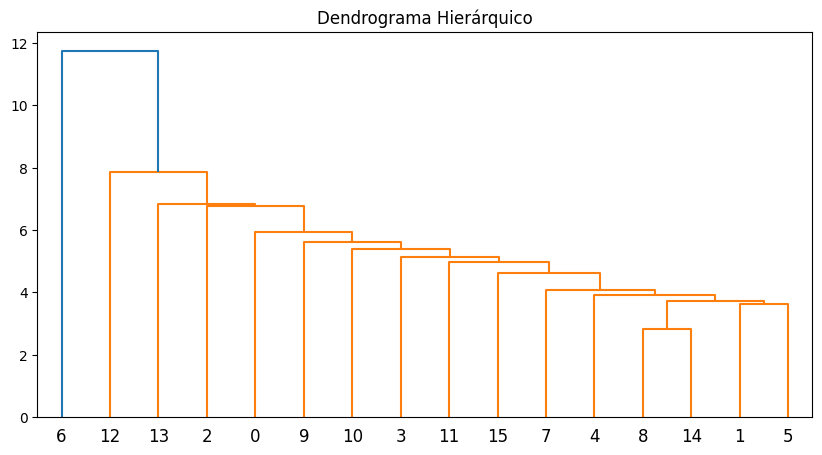

In [ ]:
from fastcluster import linkage
from scipy.cluster import hierarchy
X_pca = dataset_final.iloc[:, 5:]

X_sampled = X_pca.sample(frac=0.0005, random_state=42)

Z_fast = linkage(X_sampled, method='single')
plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z_fast)
plt.title('Dendrograma Hierárquico')
plt.show()

Este gráfico mostra um dendrograma hierárquico. Neste dendrograma, os números na base representam as amostras individuais que foram agrupadas. A altura dos links que conectam as amostras ou grupos de amostras indica a distância ou dissimilaridade entre eles. O método de ligação 'single' utilizado significa que a distância entre dois clusters é determinada pela menor distância entre quaisquer dois pontos nos clusters.

O dendrograma mostra diferentes níveis de agrupamento, com alguns clusters formados por apenas uma ou duas amostras e outros por grupos maiores, o que pode sugerir que algumas associações gene-doença são mais únicas, enquanto outras partilham semelhanças com um número maior de associações.

As distâncias verticais longas sem nenhuma ligação horizontal, como a distância entre os clusters no topo do dendrograma, indicam que esses clusters são bastante distintos um do outro em termos das suas características. Em contrapartida, distâncias verticais curtas indicam maior semelhança entre os clusters ou amostras.

#### Dendrograma Hierárquico, método 'average'

No dendrograma hierárquico com o método de ligação "average", a distância entre dois clusters é calculada como a média das distâncias entre todos os pares de pontos, um de cada cluster. 

Ao calcular a média das distâncias entre todos os pontos dos clusters, é obtida uma medida mais suave e menos sensível a outliers do que outros métodos de ligação, como o método "single", que se baseia na distância entre os pontos mais próximos dos clusters.

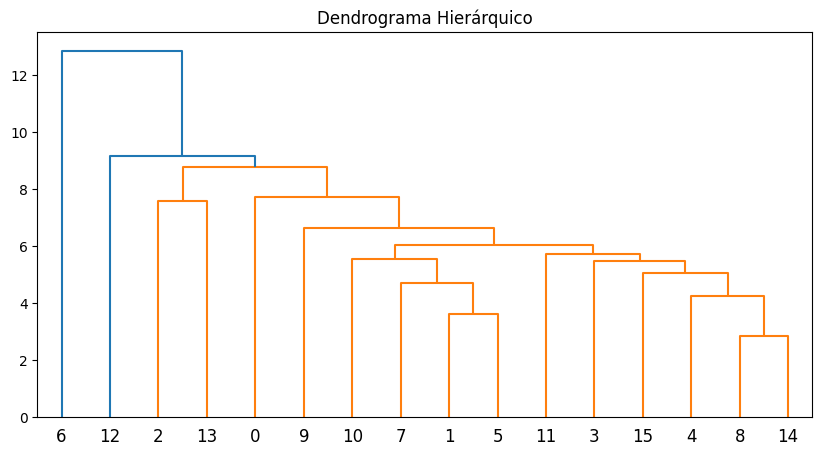

In [ ]:
X_pca = dataset_final.iloc[:, 5:]

X_sampled = X_pca.sample(frac=0.0005, random_state=42)

Z_fast = linkage(X_sampled, method='average')
plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z_fast)
plt.title('Dendrograma Hierárquico')
plt.show()

DESCREVER O GRÁFICO

#### Dendrograma Hierárquico, método 'complete'

O dendrograma hierárquico com o método 'complete' é uma representação gráfica do processo de agrupamento hierárquico em que a distância entre dois clusters é determinada pela maior distância entre quaisquer dois pontos nos clusters diferentes.

O método 'complete' tende a formar clusters mais compactos e é mais sensível a outliers em comparação com outros métodos de ligação, como o 'single'.

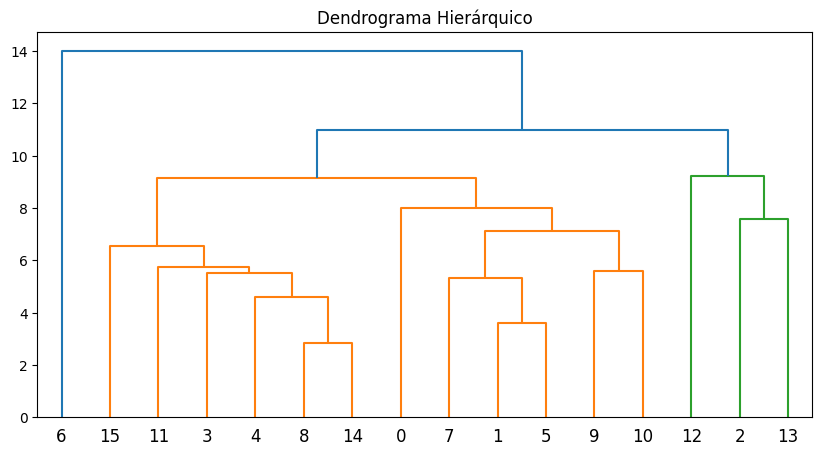

In [ ]:
from fastcluster import linkage
from scipy.cluster import hierarchy

X = dataset_final.iloc[:, 5:]

X_sampled = X.sample(frac=0.0005, random_state=42)

Z_fast = linkage(X_sampled, method='complete')
plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z_fast)
plt.title('Dendrograma Hierárquico')
plt.show()

DESCREVER GRÁFICO

## 3 - Machine Learning

Machine Learning (ML) refere-se a um conjunto de técnicas computacionais que permitem que sistemas computacionais aprendam padrões a partir de dados e melhoram o seu desempenho ao longo do tempo sem intervenção humana direta. Existem dois tipos de análises de ML: Supervisionado e Não-Supervisionado. 

* Análise Supervisionada: quando um modelo é treinado através de um conjunto de dados rotulados, onde cada exemplo de entrada está associado a uma saída conhecida. O modelo aprende a mapear as entradas para as saídas desejadas.

* Análise Não-Supervisionada: quando um modelo é treinado num conjunto de dados não rotulado e o objetivo é explorar a estrutura ou padrões intrínsecos nos dados. 

Existem vários algoritmos de ML, incluindo:
* Regressão Linear: Para modelagem de relacionamentos lineares.
* Máquinas de Vetores de Suporte (SVM): Para classificação e regressão.
* Árvores de Decisão: Para tomada de decisões baseada em regras hierárquicas.

Machine Learning pode ser aplicado a Gene-Disease Association (GDA-regressão) para prever a Associação Gene-Doença através do desenvolvimento de modelos de regressão para prever a probabilidade da associação entre um gene específico e uma doença. Como input temos as características do gene e características da doença. Como output teremos um valor contínuo que representa a força da associação.

Ao aplicar técnicas de regressão, é fundamental considerar a interpretabilidade dos modelos, especialmente em contextos biológicos, onde a compreensão das relações causa-efeito é crucial. Além disso, a validação rigorosa do modelo é essencial para garantir a generalização para novos dados.

### Embedding

Embedding é frequentemente necessário ao lidar com dados de sequências genéticas em tarefas de ML, especialmente quando se utiliza modelos específicos para sequências biológicas. Muitos modelos de linguagem pré-treinados foram desenvolvidos para lidar com texto, mas podem ser adaptados para sequências biológicas através de embedding. 

Modelos como ProtBert foram pré-treinados em grandes conjuntos de dados biológicos e podem gerar embeddings significativas para sequências de proteínas. 
Desta forma, o uso do embedding em sequências genéticas usando ProtBert está associada às características específicas deste modelo de linguagem pré-treinado. O ProtBert foi treinado especificamente para representar sequências de proteínas/sequências genéticas. Como as proteínas são produtos da expressão genética, essas sequências capturam informações cruciais sobre a estrutura e função das proteínas associadas aos genes. Utilizar o ProtBert para embedding permite ao modelo aprender representações que têm uma compreensão biologicamente significativa das sequências.

O ProtBert oferece uma abordagem poderosa e biologicamente informada para a incorporação de sequências genéticas, aproveitando o conhecimento prévio do modelo sobre a biologia molecular e as interações proteína-proteína. Esta escolha pode resultar em representações mais significativas e úteis para análises subsequentes.

In [50]:
import pandas as pd

dataset_final

NameError: name 'dataset_final' is not defined

In [79]:
pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [81]:
pip install transformers


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [47]:
#Carregar o modelo ProtBert pré-treinado
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert_bfd', do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")

In [48]:
device = torch.device('cpu') 
device 

device(type='cpu')

In [60]:
dataset_final

,Gene_ID,Gene,Disease_ID,Disease,Y,Length,Molecular Weight,_PolarizabilityC2,_PolarizabilityC3,_ChargeC2,...,_NormalizedVDWVD3100,_HydrophobicityD1025,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3075,_HydrophobicityD3100,PLI
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30,-0.141311,-0.148915,0.544780,-1.100232,0.364638,...,-0.739538,0.878123,0.324687,0.118570,0.344556,-0.209447,-0.635138,-0.076130,0.104719,-0.945468
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30,-0.141311,-0.148915,0.544780,-1.100232,0.364638,...,-0.739538,0.878123,0.324687,0.118570,0.344556,-0.209447,-0.635138,-0.076130,0.104719,-0.945468
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50,0.641182,0.634144,0.649670,-0.592836,0.555497,...,0.258046,-0.562708,0.922611,0.526594,0.344556,-0.378468,-0.255664,-0.140377,0.330608,-0.945468
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31,0.641182,0.634144,0.649670,-0.592836,0.555497,...,0.258046,-0.562708,0.922611,0.526594,0.344556,-0.378468,-0.255664,-0.140377,0.330608,-0.945468
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30,0.641182,0.634144,0.649670,-0.592836,0.555497,...,0.258046,-0.562708,0.922611,0.526594,0.344556,-0.378468,-0.255664,-0.140377,0.330608,-0.945468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31213,317772,MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGA...,C0006142,Malignant neoplasm of breast: BRCA1- and BRCA2...,0.30,-0.433047,-0.438031,-0.399224,0.252824,-0.665999,...,0.383717,-0.548128,-1.531304,-1.643810,-1.012702,0.505740,1.696166,0.392094,-5.173904,0.445792
31214,319100,MSSNSSLLVAVQLCYANVNGSCVKIPFSPGSRVILYIVFGFGAVLA...,C0005586,Bipolar Disorder: A disorder of the brain that...,0.31,-0.261202,-0.262400,-0.084556,0.281013,2.006022,...,0.276211,1.206553,0.019666,-0.250764,0.174017,-0.098448,-0.202419,0.498283,0.445239,-0.907741
31215,319100,MSSNSSLLVAVQLCYANVNGSCVKIPFSPGSRVILYIVFGFGAVLA...,C0011581,Depressive disorder: An affective disorder man...,0.31,-0.261202,-0.262400,-0.084556,0.281013,2.006022,...,0.276211,1.206553,0.019666,-0.250764,0.174017,-0.098448,-0.202419,0.498283,0.445239,-0.907741
31216,326625,MAVCGLGSRLGLGSRLGLRGCFGAARLLYPRFQSRGPQGVEDGDRP...,C0011581,Depressive disorder: An affective disorder man...,0.31,-0.337134,-0.341849,-1.212117,-0.141817,-0.322453,...,-1.099128,-0.001741,-0.434254,-0.216417,0.109330,0.040301,0.474148,0.128051,0.445239,-0.936122


In [61]:
from transformers import BertModel

# Consultar a documentação da classe BertModel
help(BertModel)


Help on class BertModel in module transformers.models.bert.modeling_bert:

class BertModel(BertPreTrainedModel)
 |  BertModel(config, add_pooling_layer=True)
 |  
 |  The bare Bert Model transformer outputting raw hidden-states without any specific head on top.
 |  
 |  This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
 |  library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
 |  etc.)
 |  
 |  This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
 |  Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
 |  and behavior.
 |  
 |  Parameters:
 |      config ([`BertConfig`]): Model configuration class with all the parameters of the model.
 |          Initializing with a config file does not load the weights associated with the model, only the
 |       

In [91]:
subset_dataset = dataset_final.head(100)
subset_dataset

,Gene_ID,Gene,Disease_ID,Disease,Y,Length,Molecular Weight,_PolarizabilityC2,_PolarizabilityC3,_ChargeC2,...,_NormalizedVDWVD3100,_HydrophobicityD1025,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3075,_HydrophobicityD3100,PLI
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30,-0.141311,-0.148915,0.544780,-1.100232,0.364638,...,-0.739538,0.878123,0.324687,0.118570,0.344556,-0.209447,-0.635138,-0.076130,0.104719,-0.945468
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30,-0.141311,-0.148915,0.544780,-1.100232,0.364638,...,-0.739538,0.878123,0.324687,0.118570,0.344556,-0.209447,-0.635138,-0.076130,0.104719,-0.945468
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50,0.641182,0.634144,0.649670,-0.592836,0.555497,...,0.258046,-0.562708,0.922611,0.526594,0.344556,-0.378468,-0.255664,-0.140377,0.330608,-0.945468
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31,0.641182,0.634144,0.649670,-0.592836,0.555497,...,0.258046,-0.562708,0.922611,0.526594,0.344556,-0.378468,-0.255664,-0.140377,0.330608,-0.945468
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30,0.641182,0.634144,0.649670,-0.592836,0.555497,...,0.258046,-0.562708,0.922611,0.526594,0.344556,-0.378468,-0.255664,-0.140377,0.330608,-0.945468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,24,MDVVLHHVPEAKLVECIGQELIFLLPNKNFKHRAYASLFRELEETL...,C0015397,Disorder of eye: A non-neoplastic or neoplasti...,0.34,0.314278,0.309689,0.964338,-0.705591,0.746355,...,0.244330,-0.280823,-0.140185,0.076524,0.234000,-0.345673,0.565027,-0.070601,-0.240859,-0.945468
96,24,MDVVLHHVPEAKLVECIGQELIFLLPNKNFKHRAYASLFRELEETL...,C0035334,Retinitis Pigmentosa: Retinitis pigmentosa (RP...,0.70,0.314278,0.309689,0.964338,-0.705591,0.746355,...,0.244330,-0.280823,-0.140185,0.076524,0.234000,-0.345673,0.565027,-0.070601,-0.240859,-0.945468
97,24,MDVVLHHVPEAKLVECIGQELIFLLPNKNFKHRAYASLFRELEETL...,C0242383,Age related macular degeneration: Age-related ...,0.70,0.314278,0.309689,0.964338,-0.705591,0.746355,...,0.244330,-0.280823,-0.140185,0.076524,0.234000,-0.345673,0.565027,-0.070601,-0.240859,-0.945468
98,24,MDVVLHHVPEAKLVECIGQELIFLLPNKNFKHRAYASLFRELEETL...,C1858806,CONE-ROD DYSTROPHY 3 (disorder): Cone-rod dyst...,0.90,0.314278,0.309689,0.964338,-0.705591,0.746355,...,0.244330,-0.280823,-0.140185,0.076524,0.234000,-0.345673,0.565027,-0.070601,-0.240859,-0.945468


In [92]:
genes = subset_dataset['Gene'].tolist() 

genes = [s.replace("", " ")[1: -1] for s in genes]

batch_size = 5 
embeddings = []

print("Total number of genes:", len(genes))

for i in range(0, len(genes), batch_size):

    print(f"Processing batch {i//batch_size + 1}...")

    batch_genes = genes[i:i+batch_size]

    ids = tokenizer.batch_encode_plus(batch_genes, add_special_tokens=True, padding='longest', return_tensors="pt")
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    with torch.no_grad():
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)[0]
        embedding = embedding.cpu().numpy()
        embeddings.append(embedding)

Total number of genes: 100
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...
Processing batch 11...
Processing batch 12...
Processing batch 13...
Processing batch 14...
Processing batch 15...
Processing batch 16...
Processing batch 17...
Processing batch 18...
Processing batch 19...
Processing batch 20...


In [93]:
for i, embedding_batch in enumerate(embeddings):
    print(f"Embeddings for Batch {i + 1}:")
    print(embedding_batch)



Embeddings for Batch 1:
[[[ 0.09069737 -0.03863281  0.05638853 ... -0.04475383 -0.07861576
   -0.08392376]
  [ 0.04433999  0.10049286  0.04808928 ...  0.1756158  -0.04348782
    0.04863616]
  [ 0.00476746  0.01343015  0.00431147 ...  0.03638579  0.03583848
   -0.06084594]
  ...
  [-0.0470142  -0.00310765 -0.02550055 ...  0.03154644 -0.0632652
   -0.04877872]
  [-0.04619927 -0.00349183 -0.0248976  ...  0.03128887 -0.06325891
   -0.04884939]
  [ 0.09070233 -0.03863304  0.05638493 ... -0.04475145 -0.07861555
   -0.08392299]]

 [[ 0.09069744 -0.03863277  0.05638858 ... -0.04475385 -0.07861581
   -0.08392374]
  [ 0.04433999  0.10049257  0.04808919 ...  0.17561567 -0.04348794
    0.04863599]
  [ 0.00476765  0.01343013  0.00431155 ...  0.0363856   0.03583844
   -0.06084572]
  ...
  [-0.04701418 -0.00310764 -0.02550054 ...  0.03154654 -0.06326526
   -0.0487788 ]
  [-0.04619915 -0.00349192 -0.02489766 ...  0.03128885 -0.06325893
   -0.0488494 ]
  [ 0.0907024  -0.03863301  0.05638488 ... -0.0447

In [95]:
gene_embeddings = embedding.mean(axis=0)
gene_embeddings

array([[ 0.09187211,  0.02872224,  0.09379143, ...,  0.02810605,
        -0.02481286,  0.00730009],
       [ 0.03088152, -0.06579407,  0.02871987, ...,  0.07618349,
         0.03662448,  0.1064631 ],
       [ 0.06080689,  0.08557476, -0.00208684, ..., -0.04921616,
         0.00578155,  0.02729703],
       ...,
       [-0.0240833 , -0.01474067,  0.07004581, ...,  0.00376143,
        -0.05376307, -0.02839731],
       [-0.08644077,  0.05403596,  0.08791696, ..., -0.02227609,
         0.02795383, -0.08553235],
       [ 0.08541203,  0.02957499,  0.09569167, ...,  0.01769909,
        -0.02934441,  0.00613119]], dtype=float32)

In [90]:

import numpy as np

all_gene_embeddings = np.concatenate(gene_embeddings, axis=0)

# Create a DataFrame
gene_embeddings_df = pd.DataFrame(all_gene_embeddings, columns=[f'Feature_{i}' for i in range(all_gene_embeddings.shape[1])])

# Display the DataFrame
print(gene_embeddings_df)

IndexError: tuple index out of range

In [96]:
embeddings_df = pd.DataFrame(gene_embeddings, columns=[f'Gene_{i}' for i in range(gene_embeddings[0].shape[0])])

In [97]:
embeddings_df #erro

,Gene_0,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_1014,Gene_1015,Gene_1016,Gene_1017,Gene_1018,Gene_1019,Gene_1020,Gene_1021,Gene_1022,Gene_1023
0,0.091872,0.028722,0.093791,-0.007180,-0.034454,-0.052706,0.004850,-0.006313,-0.009280,0.035882,...,0.049495,-0.012840,-0.075681,0.045316,-0.023415,-0.160777,0.042064,0.028106,-0.024813,0.007300
1,0.030882,-0.065794,0.028720,0.019381,-0.119185,0.021170,-0.145133,-0.089922,0.002868,-0.026949,...,-0.241568,0.168718,-0.187841,-0.000968,0.072389,-0.203730,0.148577,0.076183,0.036624,0.106463
2,0.060807,0.085575,-0.002087,-0.066635,0.003260,-0.055823,-0.033497,-0.061065,0.000091,-0.112014,...,-0.192447,0.009881,-0.057223,-0.023198,-0.112784,-0.209429,0.102833,-0.049216,0.005782,0.027297
3,0.173015,0.033994,-0.011968,-0.110391,0.038570,-0.006116,-0.050169,-0.041843,-0.039843,-0.009594,...,0.066052,-0.076230,-0.077110,-0.069353,0.128877,-0.096103,0.025860,-0.021270,0.012785,-0.033732
4,0.279353,0.030785,-0.087654,-0.089185,-0.057097,0.094754,-0.121441,0.013299,0.093944,0.030517,...,-0.049323,-0.077317,-0.117516,-0.018991,-0.027303,-0.026531,0.017651,-0.078263,0.034112,-0.001170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,-0.026570,0.040690,0.012839,-0.007238,0.032560,0.081759,-0.033098,0.045255,0.014015,0.144585,...,-0.000758,-0.044623,0.006198,0.032517,0.129096,-0.100998,0.009391,0.051544,-0.035775,0.048480
1063,-0.081227,0.000956,0.028373,-0.041030,0.088378,0.030747,-0.051744,0.062918,-0.007274,0.039141,...,0.091968,-0.104618,0.002346,0.080674,0.240241,-0.070153,-0.048369,0.003284,-0.010999,-0.005264
1064,-0.024083,-0.014741,0.070046,-0.011852,0.067790,0.087835,-0.045643,-0.015892,-0.048603,0.055460,...,-0.015979,0.011393,0.074249,0.068633,0.153889,-0.200824,0.004332,0.003761,-0.053763,-0.028397
1065,-0.086441,0.054036,0.087917,-0.086946,0.068239,0.012608,0.122385,-0.043182,-0.044744,-0.055269,...,-0.059643,-0.091843,0.093110,0.048343,0.065263,-0.185757,0.073282,-0.022276,0.027954,-0.085532


In [86]:
result_df = pd.concat([subset_dataset, embeddings_df], axis=1)

Cada linha corresponde a um gene específico, e os valores em cada coluna representam as características associadas a esse gene, conforme aprendidas pelo modelo ProtBert durante o processo de embedding.

Os valores obtidos são representações numéricas das características do gene com base nas informações capturadas pelo modelo ProtBert durante o pré-treino. 

Cada valor nos embeddings representa a ativação de uma unidade específica do modelo para uma determinada característica ou padrão na sequência de aminoácidos. O sinal positivo ou negativo indica a direção dessa ativação. Valores negativos não são incomuns e, na verdade, são uma parte natural dos resultados, refletindo as complexas relações e interações nas sequências de proteínas.

Nesse sentido, o que foi realizado foi a criação de uma lista vazia chamada 'embeddings' para armazenar os embeddings gerados para cada sequência genética. Foi iniciado um loop que itera sobre as sequências genéticas fornecidas na lista 'amino_acid_sequences' ('Gene' do nosso dataset). Foi utilizado o tokenizer para converter a sequência de aminoácidos em tokens (unidades discretas que compõem uma sequência de texto e são a entrada para o modelo). Os parâmetros 'return_tensors="pt"' indicam que temos tensores PyTorch (estruturas de dados multidimensionais que são semelhantes a arrays ou matrizes) como saída, e 'truncation=True' indica que o corte pode ser aplicado se a sequência for muito longa, no entanto, como não foi dado nenhum tamanho de corte, por default 'truncation=False'. Em seguida, foi usado o modelo ProtBert para gerar embeddings para a sequência tokenizada. O bloco 'with torch.no_grad()' é usado para desativar o rastreamento automático de gradientes durante a inferência, economizando memória. Seguidamente, é calcula a média dos embeddings ao longo da dimensão 1, que geralmente é a dimensão dos tokens. O método 'squeeze()' é utilizado para remover dimensões unitárias e, em seguida, os embeddings são convertidos para um array NumPy. Os embeddings são transformados num dataframe.

In [87]:
#Guardar o dataframe como um ficheiro csv
embeddings_df.to_csv('./data/embeddings_df.csv')

In [74]:
#Concatenar o DataFrame de embeddings com o DataFrame original
result_df = pd.concat([dataset_final, embeddings_df], axis=1)

In [88]:
result_df.head()

,Gene_ID,Gene,Disease_ID,Disease,Y,Length,Molecular Weight,_PolarizabilityC2,_PolarizabilityC3,_ChargeC2,...,Gene_1014,Gene_1015,Gene_1016,Gene_1017,Gene_1018,Gene_1019,Gene_1020,Gene_1021,Gene_1022,Gene_1023
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30,-0.141311,-0.148915,0.54478,-1.100232,0.364638,...,-0.00047,-0.020824,-0.03803,0.008471,-0.00045,-0.028725,0.001141,0.010131,-0.044506,0.019106
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30,-0.141311,-0.148915,0.54478,-1.100232,0.364638,...,-0.00047,-0.020824,-0.03803,0.008471,-0.00045,-0.028725,0.001141,0.010131,-0.044506,0.019106
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50,0.641182,0.634144,0.64967,-0.592836,0.555497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31,0.641182,0.634144,0.64967,-0.592836,0.555497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30,0.641182,0.634144,0.64967,-0.592836,0.555497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
result_df.to_csv('./data/result_df.csv')

In [ ]:
from pandas import pd
result_df = pd.read_csv(r"C:\Users\Mariana\Desktop\MSc Bioinformatics\2º ano\1º Semestre\Sistemas Inteligentes para a Bioinformática\Projeto\data\result_df.csv")

result_df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR

Com o objetivo de realizar ML, definimos as nossas variáveis como 'target' (a coluna com os valores de 'Y') e 'data_ml' (os nossos descritores):

In [ ]:
target = result_df['Y']
data_ml = result_df.iloc[:, 5:]

Usando a biblioteca scikit-learn (sklearn) importá-mos a classe StandardScaler, definimos a variável 'scaler' que é posteriormente usada para dimensionar (escalar) os dados, seguindo-se o calculo da média e do desvio padrão dos dados do data_ml. O método fit essencialmente "aprende" os parâmetros necessários para o dimensionamento. Com o método transform aplicamos a transformação de dimensionamento aos dados usando a média e o desvio padrão calculados durante o scaler, e, consequentemente, transformamos os dados originais de modo que tenham uma média de 0 e um desvio padrão de 1.

Após esse processo, os dados do data_ml estão dimensionados e prontos para serem utilizados nos algoritmos de machine learning. Este etapa permite que os algoritmos consigam convergir mais rapidamente, resultando num melhor desempenho.

Desta forma, inicializámos a análise por fazer uma standardização dos dados do data_ml e transformá-los num array:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_ml)
data_ml = scaler.transform(data_ml)

In [ ]:
data_ml

array([[-0.14131078, -0.14891483,  0.54478036, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14131078, -0.14891483,  0.54478036, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.64118209,  0.63414359,  0.64966978, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.26120243, -0.26239973, -0.08455613, ...,  0.        ,
         0.        ,  0.        ],
       [-0.33713381, -0.34184892, -1.21211734, ...,  0.        ,
         0.        ,  0.        ],
       [-0.33713381, -0.34184892, -1.21211734, ...,  0.        ,
         0.        ,  0.        ]])

Em seguida, usamos a função 'train_test_split' da biblioteca scikit-learn para dividir os dados em conjuntos de treino e teste. 

1. 'train_test_split' : esta função divide arrays em subconjuntos aleatórios para treino e teste antes de treinar os modelos de machine learning.

2. 'data_ml' : corresponde aos nossos dados (features/descritores) que vamos dividir para os modelos.

3. 'target' : é o vetor alvo associado aos dados que contém valores que os modelos vão tentar prever.

4. 'test_size=0.3' : este parâmetro define a proporção do conjunto de teste em relação ao conjunto de dados total, indicando que 30% dos dados serão usados como conjunto de teste, enquanto 70% serão usados como conjunto de treino.

5. 'random_state=42' : este parâmetro é usado para garantir reprodutibilidade nos resultados, garantindo que a divisão seja a mesma em execuções diferentes do código.

6. 'x_train, x_test' : variáveis que recebem o conjunto de features/descritores de treino e teste.

7. 'y_train, y_test' : variáveis que recebem o conjunto de labels de treino e teste.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_ml, target, test_size=0.3, random_state=42)

In [ ]:
x_train.shape, y_train.shape

((21852, 1079), (21852,))

In [ ]:
x_train

array([[-0.25720604, -0.25604895,  0.41366859, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.42457783,  0.38818265, -0.5565585 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01215054,  0.01680212,  1.06922744, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.22363638, -0.22966113,  0.07277799, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20877286,  0.17229948,  0.41366859, ...,  0.        ,
         0.        ,  0.        ],
       [-0.27638871, -0.29434405, -0.87122674, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
x_test.shape, y_test.shape

((9366, 1079), (9366,))

In [ ]:
x_test

array([[ 0.0601072 ,  0.0480576 ,  0.8070039 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26951796,  0.29362109,  1.64611922, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25001254, -0.25809985, -0.8974491 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.13811367, -0.14262078, -0.08455613, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2143678 ,  0.22236559, -1.10722793, ...,  0.        ,
         0.        ,  0.        ],
       [-0.27159304, -0.27761125,  1.1478945 , ...,  0.        ,
         0.        ,  0.        ]])

Após a execução do código acima, obtivemos quatro conjuntos de dados:

- 'x_train' : conjunto de características para treino.
- 'x_test' : conjunto de características para teste.
- 'y_train' : labels correspondentes ao conjunto de treino.
- 'y_test' : labels correspondentes ao conjunto de teste.

Esses conjuntos vão ser usados para treinar e avaliar modelos de machine learning.

### Models

Tendo em conta que estamos perante um problema de regressão, vamos utilizar modelos de regressão, nomeadamente: 
* Linear Regression;
* Random Forest Regressor;
* K-Nearest Neighbors Regressor;
* Decision Tree Regressor;
* Gradient Boosting Regressor;
* SVRegressor


Os modelos de regressão são utilizados para prever valores contínuos com base em variáveis independentes. Estes tentam encontrar a relação funcional entre as variáveis de entrada (features/descritores) e a variável de saída (ou label), que é um valor contínuo.

#### Linear Regression

A regressão linear é um modelo estatístico que assume uma relação linear entre uma variável dependente (a variável que queremos prever) e uma ou mais variáveis independentes (variáveis usadas para fazer a previsão). 
O processo de treino deste modelo consiste em encontrar os valores dos coeficientes que minimizam a soma dos quadrados dos resíduos (mínimos quadrados): método que é frequentemente utilizado para estimar os coeficientes de modo a minimizar a soma dos quadrados dos resíduos entre os valores observados e os valores previstos pelo modelo. Em seguida, é feito o ajuste do modelo: os coeficientes são ajustados iterativamente para melhor se ajustarem aos dados de treino. Por fim, o desempenho do modelo é avaliado utilizando métricas como erro quadrático médio (MSE) ou coeficiente de determinação (R^2).

In [ ]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
y_pred_lr = model_lr.predict(x_test)
print('Linear Regression:')
print('MAE: ', mean_absolute_error(y_test, y_pred_lr))
print('MSE: ', mean_squared_error(y_test, y_pred_lr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('R2: ', r2_score(y_test, y_pred_lr))

Linear Regression:
MAE:  0.08459966613340647
MSE:  0.0160012392144841
RMSE:  0.126496004737241
R2:  0.004264066486201479


#### Random Forest Regressor

O Random Forest Regressor é um modelo baseado em árvores de decisão e pertence à família de algoritmos conhecidos como "Random Forest".
Cada árvore de decisão na floresta é construída usando uma amostra aleatória do conjunto de dados e uma seleção aleatória de características, ajudando a reduzir a correlação entre as árvores e a aumentar a robustez do modelo.

Em cada divisão de nó, um subconjunto aleatório de características é considerado para dividir o nó, adicionando mais diversidade às árvores, contribuindo para a robustez do modelo.

No caso de regressão, as previsões das árvores individuais são geralmente médias para produzir a previsão final, reduzindo a variância e melhorando a estabilidade do modelo.

In [ ]:
model_rf = RandomForestRegressor()
model_rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict(x_test)
print('Random Forest Regressor:')
print('MAE: ', mean_absolute_error(y_test, y_pred_rf))
print('MSE: ', mean_squared_error(y_test, y_pred_rf))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('R2: ', r2_score(y_test, y_pred_rf))

Random Forest Regressor:
MAE:  0.07993170164081002
MSE:  0.016199861595332085
RMSE:  0.12727867690753264
R2:  -0.008095941333154055


#### K-Nearest Neighbors Regressor (KNN)

O K-Nearest Neighbors Regressor é um modelo de regressão baseado em instâncias. Este modelo prevê o valor de uma instância com base nos valores das k instâncias mais próximas no espaço de características. 

O modelo baseia-se no princípio de que instâncias semelhantes tendem a ter valores semelhantes para a variável dependente. O número de vizinhos (k) é um hiperparâmetro crucial no modelo e determina quantos vizinhos mais próximos são considerados ao fazer uma previsão. Em muitas implementações, a contribuição de cada vizinho para a previsão é ponderada pela inversa da sua distância à instância de consulta.

O KNN é um modelo não paramétrico, o que significa que não faz suposições explícitas sobre a forma da função que é modelada. Como o método é baseado na distância, é sensível à escala das variáveis. 

In [ ]:
model_KNN = KNeighborsRegressor()
model_KNN.fit(x_train, y_train)
y_pred_KNN = model_KNN.predict(x_test)  
print("KNN Regressor:")
print('MAE: ', mean_absolute_error(y_test, y_pred_KNN))
print('MSE: ', mean_squared_error(y_test, y_pred_KNN))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_KNN)))
print('R2: ', r2_score(y_test, y_pred_KNN))

KNN Regressor:
MAE:  0.08270980140935298
MSE:  0.017538992099081788
RMSE:  0.13243485983336029
R2:  -0.09142825981015168


#### Decision Tree Regressor

O Decision Tree Regressor é um modelo de regressão baseado em árvores de decisão. Árvores de decisão são estruturas hierárquicas compostas por nós que representam decisões ou testes sobre atributos, e as edges que representam os resultados desses testes. Num Decision Tree Regressor, a previsão para uma instância é dada pela média (ou outra medida de centralidade) das labels das amostras que caem nas folhas da árvore correspondentes a essa instância.

A árvore de decisão faz divisões nos dados com base em critérios, como redução de variância para problemas de regressão. Produzem regras de decisão simples que são facilmente interpretáveis. É menos sensível a outliers em comparação com alguns modelos lineares, uma vez que utiliza a mediana ou a média nas folhas. Pode modelar relações não lineares e não faz suposições explícitas sobre a forma funcional dos dados.

In [ ]:
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train, y_train)
y_pred_dtr = model_dtr.predict(x_test)  
print("Decision Tree Regressor:")
print('MAE: ', mean_absolute_error(y_test, y_pred_dtr))
print('MSE: ', mean_squared_error(y_test, y_pred_dtr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_dtr)))
print('R2: ', r2_score(y_test, y_pred_dtr))

Decision Tree Regressor:
MAE:  0.08034592157264288
MSE:  0.01726126377637246
RMSE:  0.13138212883178768
R2:  -0.07414559395100562


### Gradient Boosting Regressor

O Gradient Boosting Regressor é um modelo que faz parte da família de algoritmos conhecida como Gradient Boosting. A ideia principal por trás do Gradient Boosting é combinar várias árvores de decisão fracas para criar um modelo mais sólido e preciso.

O modelo é construído adicionando árvores, uma de cada vez, onde cada árvore tenta corrigir os erros das árvores anteriores. Cada árvore individual é relativamente rasa e é chamada de "árvore fraca" ou "estimador fraco", estas árvores têm capacidade preditiva limitada.

O modelo é treinado iterativamente, e em cada iteração, a árvore adicionada tenta corrigir os erros residuais do modelo existente. Este modelo pode incluir técnicas de regularização, como a limitação da profundidade das árvores, para evitar overfitting, e é resistente a outliers e ruídos nos dados.

In [ ]:
model_gbr = GradientBoostingRegressor()
model_gbr.fit(x_train, y_train)
y_pred_gbr = model_gbr.predict(x_test)
print('Gradient Boosting Regressor')
print('MAE: ', mean_absolute_error(y_test, y_pred_gbr))
print('MSE: ', mean_squared_error(y_test, y_pred_gbr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print('R2: ', r2_score(y_test, y_pred_gbr))

Gradient Boosting Regressor
MAE:  0.0825952735513839
MSE:  0.015481998231015114
RMSE:  0.12442667813220408
R2:  0.03657574550448084


### Support Vector Regression

O SVR é uma implementação do algoritmo de máquinas de vetores de suporte (SVM) para problemas de regressão. Este modelo tenta encontrar a função que melhor se ajusta aos dados de treino, tendo em consideração a presença de margens de erro (slack) para lidar com dados que não são linearmente separáveis.

In [ ]:
model_svr = SVR()
model_svr.fit(x_train, y_train)
y_pred_svr = model_svr.predict(x_test)
print('SVR')
print('MAE: ', mean_absolute_error(y_test, y_pred_svr))
print('MSE: ', mean_squared_error(y_test, y_pred_svr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_svr)))
print('R2: ', r2_score(y_test, y_pred_svr))

SVR
MAE:  0.1016291511453535
MSE:  0.017028802941696706
RMSE:  0.13049445559753375
R2:  -0.05967986394606095


### Visualização Gráfica

Para uma melhor interpretação dos resultados de ML, através da biblioteca 'scikit-learn', é possível visualizar o erro de previsão nos modelos de regressão treinados ('y_pred_model'). 

O método 'PredictionErrorDisplay.from_predictions' é usado para criar gráficos de erro de previsão, mostrando a relação entre os valores reais ('y_test') e as previsões do modelo ('y_pred_model'). 

O parâmetro 'kind' é definido como "actual_vs_predicted", indicando que o gráfico mostrará a relação entre os valores reais e as previsões. O parâmetro 'subsample' é configurado para mostrar um subconjunto de pontos para melhorar a visualização, especialmente importante uma vez que estamos perante um conjunto de dados consideravelmente grande.

Os gráficos exibem métricas de avaliação do desempenho do modelo, como MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error) e R² (coeficiente de determinação).

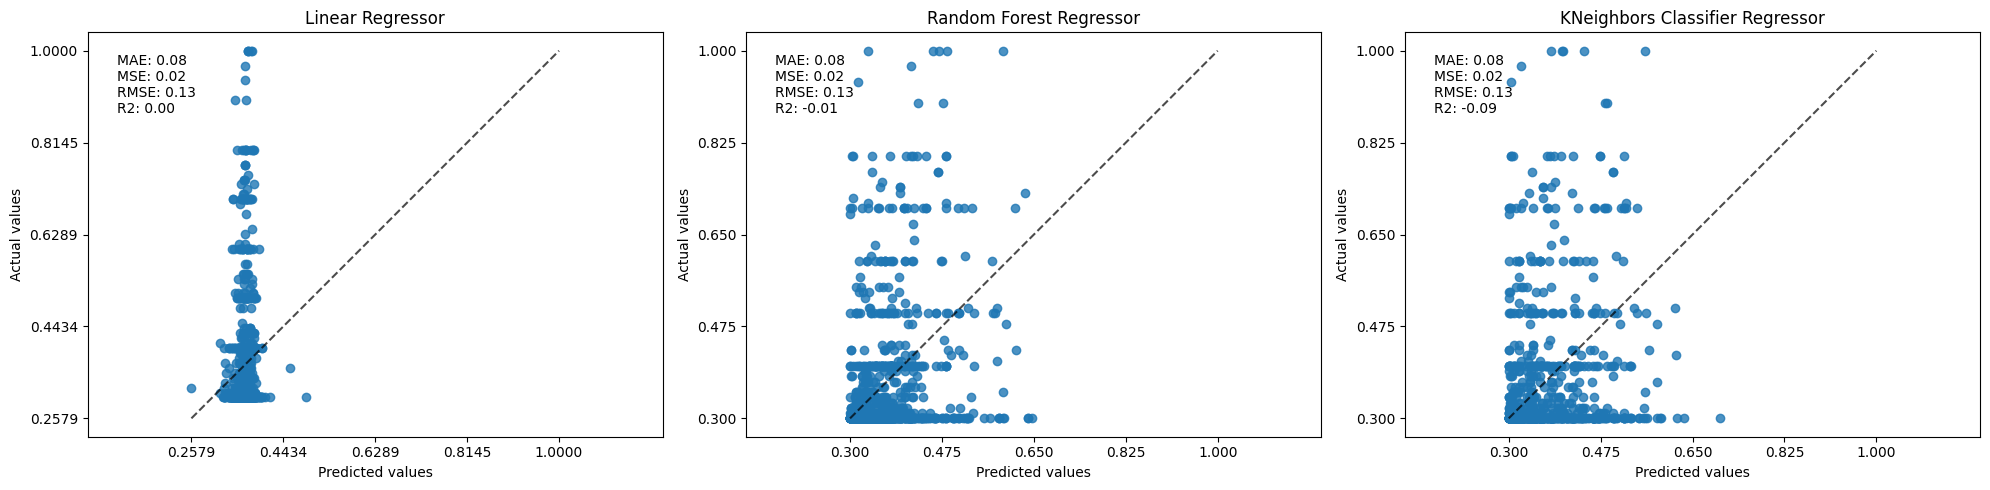

In [ ]:
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Linear Regressor")
axs[0].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_lr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}\nR2: {r2_score(y_test, y_pred_lr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_rf,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Random Forest Regressor")
axs[1].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}\nMSE: {mean_squared_error(y_test, y_pred_rf):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}\nR2: {r2_score(y_test, y_pred_rf):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_KNN,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[2],
    random_state=0,
)
axs[2].set_title("KNeighbors Classifier Regressor")
axs[2].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_KNN):.2f}\nMSE: {mean_squared_error(y_test, y_pred_KNN):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_KNN)):.2f}\nR2: {r2_score(y_test, y_pred_KNN):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

plt.tight_layout()
plt.show()

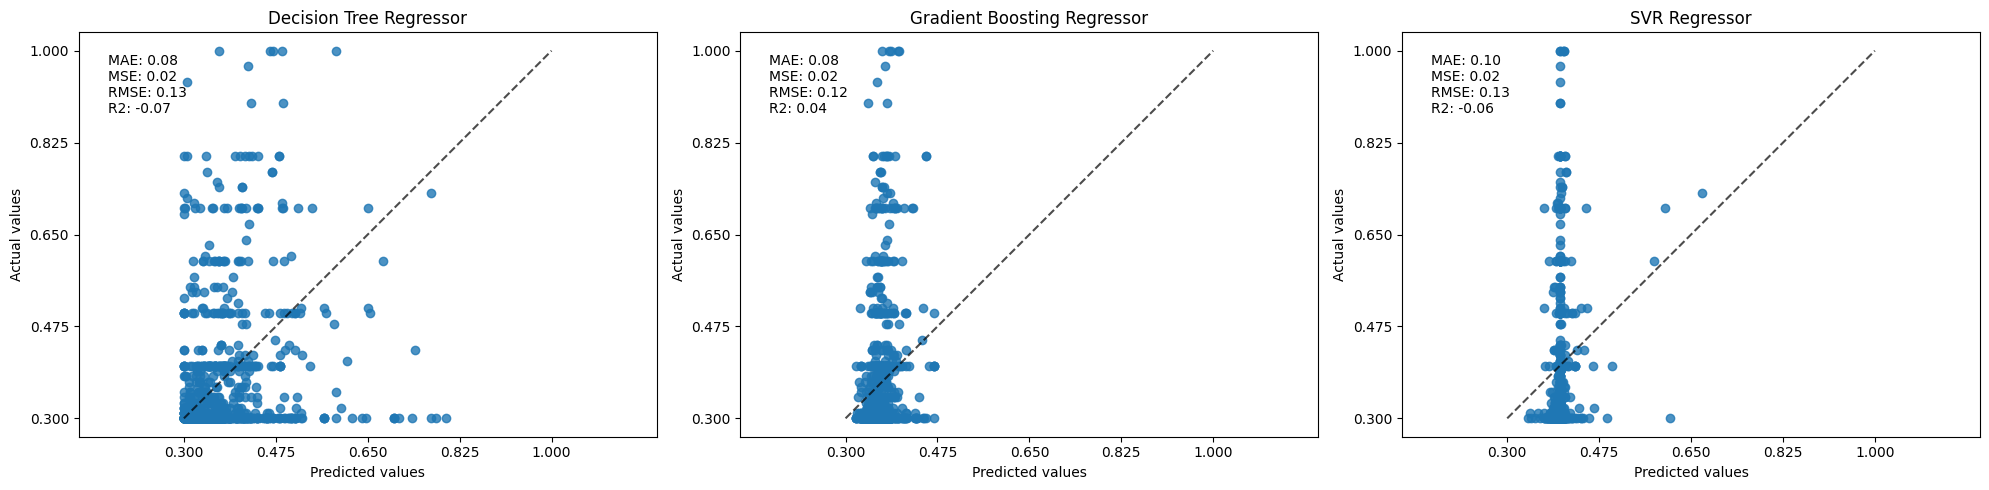

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_dtr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Decision Tree Regressor")
axs[0].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_dtr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_dtr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dtr)):.2f}\nR2: {r2_score(y_test, y_pred_dtr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_gbr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[1],
    random_state=0,
)

axs[1].set_title("Gradient Boosting Regressor")
axs[1].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_gbr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_gbr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gbr)):.2f}\nR2: {r2_score(y_test, y_pred_gbr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_svr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[2],
    random_state=0,
)
axs[2].set_title("SVR Regressor")
axs[2].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_svr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_svr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_svr)):.2f}\nR2: {r2_score(y_test, y_pred_svr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

plt.tight_layout()
plt.show()

### Melhor Modelo

Para avaliar e perceber qual o melhor modelo neste problema de regressão, foi considerada a medida Erro Quadrático Médio (MSE) que corresponde à média das diferenças quadráticas entre as previsões e os valores reais. MSE mede a dispersão dos erros e penaliza erros grandes mais do que erros pequenos. Neste caso, preferimos penalizar mais erros maiores, e então o MSE é o mais apropriado. 

O melhor modelo nexte contexto será aquele que apresenta um valor de MSE menor.

In [ ]:
mse_results = [
    {'Model': 'Linear Regression', 'MSE': mean_squared_error(y_test, y_pred_svr)},
    {'Model': 'Random Forest Regressor', 'MSE': mean_squared_error(y_test, y_pred_rf)},
    {'Model': 'KNN Regressor', 'MSE': mean_squared_error(y_test, y_pred_KNN)},
    {'Model': 'Decision Tree Regressor', 'MSE': mean_squared_error(y_test, y_pred_dtr)},
    {'Model': 'Gradient Boosting Regressor', 'MSE': mean_squared_error(y_test, y_pred_gbr)},
    {'Model': 'SVRegressor', 'MSE': mean_squared_error(y_test, y_pred_svr)}
]

min_mse_result = min(mse_results, key=lambda x: x['MSE'])

print(f"Modelo com o menor MSE: {min_mse_result['Model']}")
print(f"MSE mínimo: {min_mse_result['MSE']}")

Modelo com o menor MSE: Gradient Boosting Regressor
MSE mínimo: 0.015481998231015114


Como resultado, obtivemos o Gradient Boosting Regressor como o melhor modelo para o problema GDA.

Seguidamente, procedeu-se à determinação das 10 características mais importantes:

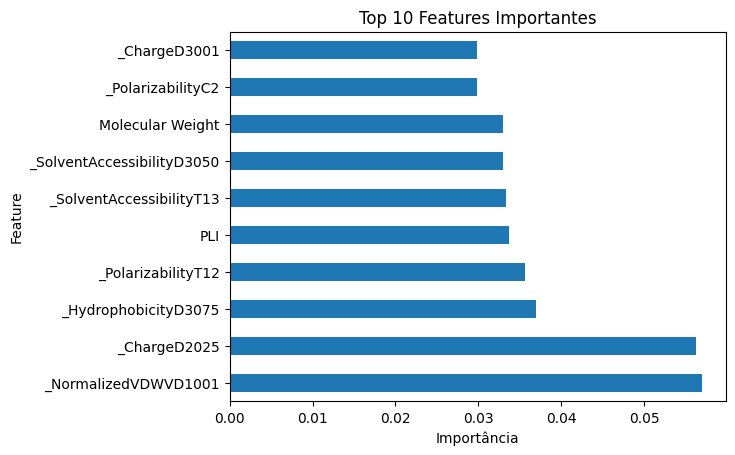

In [ ]:
best_model = GradientBoostingRegressor()
best_model.fit(x_train, y_train)
best_model.feature_importances_

importances = pd.Series(best_model.feature_importances_, index = result_df.iloc[:, 5:].columns)
top_features = importances.nlargest(10)
top_features.plot(kind='barh')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.title('Top 10 Features Importantes')
plt.show()

## 4 - Deep Learning

Referências:\
[1] Piñero, Janet, et al. “The DisGeNET knowledge platform for disease genomics: 2019 update.” Nucleic acids research 48.D1 (2020): D845-D855.\
[2] Halavi, Maryam, et al. “MedGen.” The NCBI Handbook [Internet]. 2nd edition. National Center for Biotechnology Information (US), 2018.\
Dataset License: CC BY-NC-SA 4.0.